# Introduction
As young professionals residing in Shanghai, where housing expenses can consume a substantial part of our monthly income, the quest for the perfect rental apartment poses a considerable challenge.

In an effort to streamline this process and provide valuable insights to fellow individuals facing similar challenges, I am delving into an in-depth study of Shanghai's rental market. This research encompasses pinpointing subareas that offer optimal value for money, evaluating housing availability, and establishing fair pricing benchmarks considering factors such as location and amenities.

The ultimate objective is to empower individuals with the information needed to make well-informed decisions during house visits and to critically assess the reasonableness of prices quoted by agents.

## Data information
I conducted web scraping on the leading Chinese apartment rental and sales website, https://sh.lianjia.com/.

Lianjia was selected for its known reliability in providing authentic and well-structured information, setting it apart from other platforms that might feature fictional listings. This choice ensures the precision of the subsequent analysis.

After an extensive crawling process, over 12,000 rental listings were acquired as of January 1, 2024.

## Features information

17 features are considered:

* **area(sqm)**: Total area of the property in square meters.
* **has_elevator**: Indicates whether the property is equipped with an elevator.
* **has_parking**: Indicates whether the property is equipped with a parking lot.
* **water_type**: Specifies the water supply for residential and commercial use.
* **electricity_type**: Specifies the electricity supply for residential and commercial use.
* **gas**: Indicates whether the property is supplied with gas.
* **heating**: Specifies the type of heating system.
* **num_living_R**: Number of living rooms.
* **num_bed_R**: Number of bedrooms.
* **num_bath_R**: Number of bathrooms.
* **deco_type**: Indicates whether the property is well-renovated or poorly-renovated.
* **height_level**: Indicates the low/middle/high position of the property within the building.
* **total_floor**: Total number of floors in the building.
* **num_Mlines**: Number of nearby metro lines.
* **dist_to_metro**: Proximity to the metro station.
* **num_metro_stations_in_1km**: Number of metro stations within a 1KM radius.
* **south**: Does the main balcony face south?
* **east**: Does the main balcony face east?

# Import libraries

In [1]:
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.spatial import KDTree
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
plt.rcParams['font.family'] = 'Arial Unicode MS'

# Cleaning and peocessing data

In [3]:
df = pd.read_csv('sh_home_data')
df.head()

link             house_code  \
0  https://sh.lianjia.com/zufang/SH18367409098745...  SH1836740909874544640   
1  https://sh.lianjia.com/zufang/SH18302064453295...  SH1830206445329580032   
2  https://sh.lianjia.com/zufang/SH18504871892557...  SH1850487189255749632   
3  https://sh.lianjia.com/zufang/SH18363578896571...  SH1836357889657143296   
4  https://sh.lianjia.com/zufang/SH18595773397011...  SH1859577339701100544   

  district subarea compound_name               title  price lease_mode  \
0       嘉定      南翔      海伦堡爱ME城市  整租·海伦堡爱ME城市 1室1厅 南   3200         整租   
1       徐汇      龙华          东安五村      整租·东安五村 1室1厅 南   6300         整租   
2       嘉定    嘉定老城       塔城路850弄   整租·塔城路850弄 2室2厅 南   2800         整租   
3       静安     曹家渡          中行小区      整租·中行小区 1室1厅 南   2900         整租   
4       静安      大宁          宁和小区      整租·宁和小区 1室1厅 南   3000         整租   

           type_area orient_floor  ... has_parking water_type  \
0  1室1厅1卫 60.00㎡ 精装修    南 低楼层/31层  ...        暂无数据         商水   
1  1室1厅1卫 33.06㎡ 精装修     南 中楼层/4层  ...        暂无数据         民水   
2  2室2厅1卫 82.90㎡ 精装修     南 高楼层/6层  ...        暂无数据         民水   
3      1室1厅1卫 22.80㎡     南 中楼层/5层  ...        暂无数据       暂无数据   
4      1室1厅1卫 37.71㎡     南 高楼层/6层  ...        租用车位         民水   

  electricity_type gas heating lease_period house_visit          house_tags  \
0               商电   无     自采暖         暂无数据       需提前预约            精装,非居住房屋   
1               民电   有     自采暖         1年以内       需提前预约    官方核验,近地铁,精装,随时看房   
2               民电   有     自采暖         1年以内       需提前预约             官方核验,精装   
3             暂无数据   有     自采暖         2年以内       需提前预约  必看好房,官方核验,近地铁,随时看房   
4               民电   有     自采暖         1年以内       需提前预约  必看好房,官方核验,近地铁,随时看房   

                  facilities house_desc  
0                      衣柜,暖气        NaN  
1              洗衣机,空调,冰箱,热水器        NaN  
2                        NaN        NaN  
3     洗衣机,空调,衣柜,冰箱,热水器,床,天然气        NaN  
4  洗衣机,空调,衣柜,电视,冰箱,热水器,床,天然气        NaN  

[5 rows x 28 columns]

In [4]:
df.shape

(12522, 28)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12522 entries, 0 to 12521
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   link                12522 non-null  object
 1   house_code          12522 non-null  object
 2   district            12522 non-null  object
 3   subarea             12522 non-null  object
 4   compound_name       12522 non-null  object
 5   title               12522 non-null  object
 6   price               12522 non-null  int64 
 7   lease_mode          12522 non-null  object
 8   type_area           12522 non-null  object
 9   orient_floor        12522 non-null  object
 10  last_maintain_time  12522 non-null  object
 11  coordinate          12522 non-null  object
 12  metro               8066 non-null   object
 13  area                12522 non-null  object
 14  orientation         12522 non-null  object
 15  check_in            12522 non-null  object
 16  floor               12

In [6]:
df.check_in.value_counts()

随时入住          11027
2024-03-01      181
2024-03-19      176
2024-03-15      129
2024-03-10      101
2024-03-05       67
2024-03-20       63
2024-03-03       56
2024-03-02       49
2024-03-18       48
2024-03-04       47
暂无数据             47
2024-03-11       42
2024-03-08       41
2024-03-06       40
2024-03-09       35
2024-03-16       33
2024-03-25       26
2024-03-14       25
2024-03-12       25
2024-03-13       25
2024-03-07       24
2024-03-27       24
2024-03-31       21
2024-03-23       20
2024-03-24       19
2024-03-22       18
2024-03-28       17
2024-03-21       17
2024-03-17       17
2024-04-01       16
2024-03-30       14
2024-03-26        8
2024-03-29        6
2024-04-02        5
2024-04-07        4
2024-02-29        3
2024-04-05        1
2024-04-03        1
2024-04-12        1
2025-03-19        1
2024-04-08        1
2024-04-04        1
Name: check_in, dtype: int64

In [7]:
df.lease_period.value_counts()

暂无数据       5085
1年以内       3193
2年以内       2083
3年以内       1229
1年          259
1~2年        248
3年以上        166
2~12个月       69
7~12个月       67
2~24个月       25
6~12个月       20
4~7个月        18
1~3年         15
2~4个月        10
1~3个月         8
2~7个月         8
6~36个月        5
6~24个月        4
1年以上          4
3~36个月        1
3~12个月        1
11~36个月       1
6个月以上         1
1~7个月         1
3个月以上         1
Name: lease_period, dtype: int64

In [8]:
df.house_visit.value_counts()

需提前预约      9397
随时可看       2706
一般下班后可看     320
只能周末看房       97
暂无数据          2
Name: house_visit, dtype: int64

In [9]:
df.house_desc.value_counts()

暂无                                                                                                                                                                                                                                                                                                                                  122
【交通出行】\n5号线，15号线，23号线（规划中）门口有公交车站直达莘庄，虹桥枢纽4路直达虹桥火车站，亦有闵行26路可到浦江八号线地铁站。\n\n【周边配套】\n欧尚置业广场，龙湖闵行天街，紫竹高新开发科技园区，闵行湿地公园，欧尚大卖场，碧江广场生活娱乐购物一体式。\n\n【小区介绍】\n小区环境舒适，实用空间多，可存储，生活配套齐全，在小区过一个马路，右边有一个大型商场，也有2个地铁站和两个高速进入口。\n\n                                                                                                                     7
小区环境优美，绿化面积较高，地理位置好。\n温馨舒适，采光好，看房随时，拎包入住。\n周围设置齐全：交通，购物等都很方便。                                                                                                                                                                                                                                                                         6
【房源亮点】\n公园：世纪公园，

**Primary data exploring**:

* The dataset comprises 12,522 entries and 28 variables.
* `link` and `house_code` serve as identifiers for each apartment but are not pertinent to price regression.
* `title` duplicates information encompassing `lease_mode`, `compound_name`, `type_area`, and `orientation`.
* `orient_floor` redundantly contains information from both `orientation` and `floor`.
* `lease_mode` features only one unique value, rendering it non-informative.
* `last_maintain_time` represents the last time the apartment information on the webpage was maintained by the agency, but scattered date information renders it unhelpful.
* `check_in` indicates the earliest tenant move-in time, with scattered date information that is not useful.
* `lease_period` reflects the intended rental period by the landlord, but scattered date information is not useful.
* `house_visit` denotes the weekly time period during which tenants can visit the apartment.
* `type_area` encompasses information on the living room, bedroom, bathroom count, total area in square meters, and renovation type.
* `house_desc` provides a subjective introduction to the residential quarter, not directly impacting the price.
* `floor` specifies the position of the apartment within the entire building and the total number of floors in the building.
* `house_tag` includes duplicated information found in other features. However, the presence of the tag `非居住住房` indicating non-residential use, potentially for office or commercial purposes, significantly influences the price.

## Removing irrelevant features

In [10]:
df.drop(['link', 'house_code', 'lease_mode', 'title', 'orient_floor',
        'last_maintain_time', 'check_in', 'lease_period', 'house_desc'], axis=1, inplace=True)
df.head()

district subarea compound_name  price          type_area  \
0       嘉定      南翔      海伦堡爱ME城市   3200  1室1厅1卫 60.00㎡ 精装修   
1       徐汇      龙华          东安五村   6300  1室1厅1卫 33.06㎡ 精装修   
2       嘉定    嘉定老城       塔城路850弄   2800  2室2厅1卫 82.90㎡ 精装修   
3       静安     曹家渡          中行小区   2900      1室1厅1卫 22.80㎡   
4       静安      大宁          宁和小区   3000      1室1厅1卫 37.71㎡   

                coordinate                                              metro  \
0     121.337172,31.286038                                                NaN   
1  121.4585585,31.19057846  ['7号线,12号线 ', ' 龙华中路', '530m'],['11号线(嘉定北-迪士尼)...   
2  121.2447388,31.37808454                                                NaN   
3  121.4401498,31.23302397  ['14号线 ', '  武定路', '7m'],['13号线,14号线 ', ' 武宁路'...   
4     121.456775,31.280534  ['1号线 ', ' 延长路', '328m'],['1号线 ', ' 上海马戏城', '8...   

     area orientation    floor has_elevator has_parking water_type  \
0  60.00㎡           南  低楼层/31层            有        暂无数据         商水   
1  33.06㎡           南   中楼层/4层            无        暂无数据         民水   
2  82.90㎡           南   高楼层/6层            无        暂无数据         民水   
3  22.80㎡           南   中楼层/5层            无        暂无数据       暂无数据   
4  37.71㎡           南   高楼层/6层            无        租用车位         民水   

  electricity_type gas heating house_visit          house_tags  \
0               商电   无     自采暖       需提前预约            精装,非居住房屋   
1               民电   有     自采暖       需提前预约    官方核验,近地铁,精装,随时看房   
2               民电   有     自采暖       需提前预约             官方核验,精装   
3             暂无数据   有     自采暖       需提前预约  必看好房,官方核验,近地铁,随时看房   
4               民电   有     自采暖       需提前预约  必看好房,官方核验,近地铁,随时看房   

                  facilities  
0                      衣柜,暖气  
1              洗衣机,空调,冰箱,热水器  
2                        NaN  
3     洗衣机,空调,衣柜,冰箱,热水器,床,天然气  
4  洗衣机,空调,衣柜,电视,冰箱,热水器,床,天然气

In [11]:
df.heating.value_counts()

自采暖     8283
暂无数据    4002
集中供暖     237
Name: heating, dtype: int64

In [12]:
df.subarea.value_counts()

南翔     307
高行     289
龙华     288
九亭     278
梅园     270
      ... 
万祥镇      2
合庆       2
洞泾       1
柘林       1
重固       1
Name: subarea, Length: 188, dtype: int64

## Get an overview of the distribution of all features

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12522 entries, 0 to 12521
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   district          12522 non-null  object
 1   subarea           12522 non-null  object
 2   compound_name     12522 non-null  object
 3   price             12522 non-null  int64 
 4   type_area         12522 non-null  object
 5   coordinate        12522 non-null  object
 6   metro             8066 non-null   object
 7   area              12522 non-null  object
 8   orientation       12522 non-null  object
 9   floor             12522 non-null  object
 10  has_elevator      12522 non-null  object
 11  has_parking       12522 non-null  object
 12  water_type        12522 non-null  object
 13  electricity_type  12522 non-null  object
 14  gas               12522 non-null  object
 15  heating           12522 non-null  object
 16  house_visit       12522 non-null  object
 17  house_tags  

## Check missing values

In [14]:
columns_with_null = df.isnull().any()
columns_with_null

district            False
subarea             False
compound_name       False
price               False
type_area           False
coordinate          False
metro                True
area                False
orientation         False
floor               False
has_elevator        False
has_parking         False
water_type          False
electricity_type    False
gas                 False
heating             False
house_visit         False
house_tags           True
facilities           True
dtype: bool

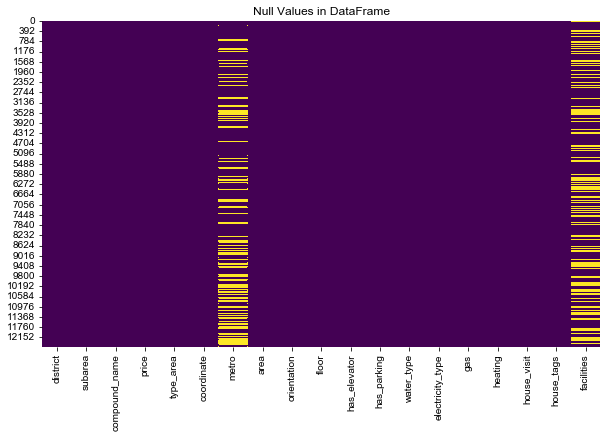

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values in DataFrame')
plt.show()

* We observe that the features `metro`, `house_tags`, and `facilities` contain null values.
* In the subsequent stages, I will address these features and handle the null entries appropriately.

## Extract information from single feature

In [16]:
df.type_area

0        1室1厅1卫 60.00㎡ 精装修
1        1室1厅1卫 33.06㎡ 精装修
2        2室2厅1卫 82.90㎡ 精装修
3            1室1厅1卫 22.80㎡
4            1室1厅1卫 37.71㎡
               ...        
12517    2室2厅1卫 82.90㎡ 精装修
12518    1室1厅1卫 33.06㎡ 精装修
12519    2室2厅1卫 82.90㎡ 精装修
12520    1室1厅1卫 33.06㎡ 精装修
12521    2室2厅1卫 82.90㎡ 精装修
Name: type_area, Length: 12522, dtype: object

**type_area info**:
* It encompasses details regarding the **number of living rooms**, **number of bedrooms**, and **number of bathrooms**, along with the **total area of the apartment in square meters** and the **renovation type**.
* Typically, if specified as "精装房" (Fully Renovated), it indicates a property that has undergone extensive interior decoration, often featuring high-quality finishes and furnishings.
* In cases where the renovation type is not specified, it can be considered as either ordinarily renovated or a Bare Shell property.

In [17]:
# Split "type_area" into number of rooms and decoration types
df['num_living_R'] = df['type_area'].apply(lambda x: int(x[0]))
df['num_bed_R'] = df['type_area'].apply(lambda x: int(x[2]))
df['num_bath_R'] = df['type_area'].apply(lambda x: int(x[4]))
df['deco_type'] = df['type_area'].apply(lambda x: x.split(' ')[2] if len(x.split(' ')) == 3 else '非精装')

# Drop "type_area" feature
df.drop('type_area', axis=1, inplace=True)

In [18]:
df.floor

0        低楼层/31层
1         中楼层/4层
2         高楼层/6层
3         中楼层/5层
4         高楼层/6层
          ...   
12517     高楼层/6层
12518     中楼层/4层
12519     高楼层/6层
12520     中楼层/4层
12521     高楼层/6层
Name: floor, Length: 12522, dtype: object

In [19]:
df.floor.value_counts()

高楼层/6层     2215
中楼层/6层     1327
低楼层/6层      704
中楼层/11层     360
中楼层/5层      333
           ... 
3/22层         1
4/4层          1
11/16层        1
4/14层         1
3/21层         1
Name: floor, Length: 367, dtype: int64

In [20]:
# Split "floor" into position in height level and total floors
df['height_level'] = df['floor'].apply(lambda x: x.split('/')[0][0])
df['total_floor'] = df['floor'].apply(lambda x: eval(list(x.split('/'))[1][:-1]))

In [21]:
df.height_level.value_counts()

高    4397
中    4228
低    3139
1     172
2     123
4     112
6      98
3      92
5      89
7      31
8      24
9      17
Name: height_level, dtype: int64

In [22]:
# Define a helper function to convert exact floor number into height_level
def calculate_level(x):
  for i, item in enumerate(x):
    if re.match(r'\d+', item):
      item = int(item)
      level_v = item/int(df['total_floor'][i])
      if level_v < 1/3:
        return '低'
      elif level_v > 1/3 and level_v<2/3:
        return '中'
      else:
        return '高'
    else:
      return item

In [23]:
df['height_level'] = df['height_level'].apply(calculate_level)

In [24]:
df.height_level.value_counts()

高    4397
中    4228
低    3897
Name: height_level, dtype: int64

In [25]:
df.drop('floor', axis=1, inplace=True)

In [26]:
df.area

0        60.00㎡
1        33.06㎡
2        82.90㎡
3        22.80㎡
4        37.71㎡
          ...  
12517    82.90㎡
12518    33.06㎡
12519    82.90㎡
12520    33.06㎡
12521    82.90㎡
Name: area, Length: 12522, dtype: object

In [27]:
# Convert string into numerical one
df['area'] = df['area'].apply(lambda x: float(x[:-1]))

# Change the column name with unit
df = df.rename(columns = {'area':'area(sqm)'})

In [28]:
# Check all house tags
df.house_tags

0                  精装,非居住房屋
1          官方核验,近地铁,精装,随时看房
2                   官方核验,精装
3        必看好房,官方核验,近地铁,随时看房
4        必看好房,官方核验,近地铁,随时看房
                ...        
12517               官方核验,精装
12518      官方核验,近地铁,精装,随时看房
12519               官方核验,精装
12520      官方核验,近地铁,精装,随时看房
12521               官方核验,精装
Name: house_tags, Length: 12522, dtype: object

In [29]:
# Check all tags in house_tags feature
tags = []
for x in df.house_tags:
  tags.extend(str(x).split(','))

list(set(tags))

['必看好房',
 '双卫生间',
 '官方核验',
 '公寓',
 '非居住房屋',
 '近地铁',
 '贝壳省心租',
 '月租',
 '精装',
 '动迁安置房',
 '随时看房',
 '新上',
 '独立卫生间',
 '独立阳台',
 '业主自荐',
 '押一付一',
 'nan']

**house_tags info**:
* The `house_tags` feature includes information such as "official verified," "agency name," and "payment method," duplicating details found in other variables like "renovation type," "number of bathrooms," "reservation requirement," "proximity to metro," and more.

* A significant tag within this feature is `非居住住房`, indicating non-residential use, potentially for office or commercial purposes.

* Considering the project's focus on providing insights for young professionals seeking residential spaces, non-residential properties will not be considered in this analysis.

In [30]:
# Check if there is NaN value for this feature
df[df.house_tags.isnull()]

district subarea compound_name  price          coordinate metro  \
3589       浦东      御桥        康桥阳光大厦   2300  121.5738,31.154629   NaN   

      area(sqm) orientation has_elevator has_parking  ... heating house_visit  \
3589      30.05           南            有        暂无数据  ...    暂无数据       需提前预约   

     house_tags facilities num_living_R num_bed_R num_bath_R  deco_type  \
3589        NaN        NaN            1         1          1        非精装   

      height_level  total_floor  
3589             中            8  

[1 rows x 23 columns]

In [31]:
# Only one data record contains NaN value, remove it
df.drop(df[df.house_tags.isnull()].index, inplace=True)

In [32]:
df.drop(df[df.house_tags.str.contains('非居住')].index, inplace=True)
df.head()

district subarea compound_name  price               coordinate  \
1       徐汇      龙华          东安五村   6300  121.4585585,31.19057846   
2       嘉定    嘉定老城       塔城路850弄   2800  121.2447388,31.37808454   
3       静安     曹家渡          中行小区   2900  121.4401498,31.23302397   
4       静安      大宁          宁和小区   3000     121.456775,31.280534   
5       静安      彭浦      临汾路1565弄   3000     121.443627,31.316021   

                                               metro  area(sqm) orientation  \
1  ['7号线,12号线 ', ' 龙华中路', '530m'],['11号线(嘉定北-迪士尼)...      33.06           南   
2                                                NaN      82.90           南   
3  ['14号线 ', '  武定路', '7m'],['13号线,14号线 ', ' 武宁路'...      22.80           南   
4  ['1号线 ', ' 延长路', '328m'],['1号线 ', ' 上海马戏城', '8...      37.71           南   
5                                                NaN      40.42           南   

  has_elevator has_parking  ... heating house_visit          house_tags  \
1            无        暂无数据  ...     自采暖       需提前预约    官方核验,近地铁,精装,随时看房   
2            无        暂无数据  ...     自采暖       需提前预约             官方核验,精装   
3            无        暂无数据  ...     自采暖       需提前预约  必看好房,官方核验,近地铁,随时看房   
4            无        租用车位  ...     自采暖       需提前预约  必看好房,官方核验,近地铁,随时看房   
5            无        暂无数据  ...     自采暖       需提前预约           必看好房,官方核验   

                  facilities num_living_R num_bed_R num_bath_R  deco_type  \
1              洗衣机,空调,冰箱,热水器            1         1          1        精装修   
2                        NaN            2         2          1        精装修   
3     洗衣机,空调,衣柜,冰箱,热水器,床,天然气            1         1          1        非精装   
4  洗衣机,空调,衣柜,电视,冰箱,热水器,床,天然气            1         1          1        非精装   
5              洗衣机,空调,冰箱,热水器            1         1          1        非精装   

   height_level  total_floor  
1             中            4  
2             高            6  
3             中            5  
4             高            6  
5             高            6  

[5 rows x 23 columns]

non_residential = df[df.house_tags.str.contains('非居住')]
residential = df[~df.house_tags.str.contains('非居住')]

print(f'Number of non-residential records: {len(non_residential)}, making up {len(non_residential)/len(df)*100:.2f}% of the total entries.')
print(f'Number of residential records: {len(residential)}, making up {len(residential)/len(df)*100:.2f}% of the total entries.')

In [33]:
# Drop the non-residential property
df.drop(df[df['house_tags'].str.contains('非居住')].index)

# Drop "house_tags" feature
df.drop('house_tags', axis=1, inplace=True)

In [34]:
df.coordinate

1        121.4585585,31.19057846
2        121.2447388,31.37808454
3        121.4401498,31.23302397
4           121.456775,31.280534
5           121.443627,31.316021
                  ...           
12517    121.2447388,31.37808454
12518    121.4585585,31.19057846
12519    121.2447388,31.37808454
12520    121.4585585,31.19057846
12521    121.2447388,31.37808454
Name: coordinate, Length: 11541, dtype: object

**coordinate info**:
* It appears that the coordinate feature, by its nature, represents the exact geographical location and should consist of numerical values.
* Therefore, the strings need to be converted into floating-point numbers and split into longitude and latitude components.

In [35]:
# create new columns to store for longitude and latitude value separately , as float
df['longitude'] = df['coordinate'].str.split(',').str[0].astype(float)
df['latitude'] = df['coordinate'].str.split(',').str[1].astype(float)

# Drop "coordinate" feature
df.drop('coordinate', axis=1, inplace=True)

In [36]:
# Check "metro" feature
df.metro[1]

"['7号线,12号线 ', ' 龙华中路', '530m'],['11号线(嘉定北-迪士尼),11号线(花桥-迪士尼),12号线 ', ' 龙华', '983m'],['4号线 ', ' 上海体育场', '1065m'],['4号线,7号线 ', ' 东安路', '1065m']"

**metro info**:
* The information includes the accurate street where the apartment is located, proximity to the metro, which is duplicated with the coordinate feature.
* It also contains the subarea, which is already present in the subarea feature.
* For simplicity, we choose to retain only the metro lines information.

In [37]:
# Defeine a map function to ectract number of metro lines from "metro" feature
def num_Metro_lines(x):
  if x is np.nan:
    return 0
  else:
    pattern = re.compile(r'\d+号线')
    lists = ast.literal_eval("[" + x + "]")
    all_items = [item for sublist in lists for item in sublist]
    all_items = ','.join(all_items)
    matches = pattern.findall(all_items)
    num_lines = len(set(matches))
    return num_lines

In [38]:
# Create a new feature "num_Mlines" to the DataFrame
df['num_Mlines'] = df['metro'].apply(num_Metro_lines)

# Drop "metro" column
df.drop('metro', axis=1, inplace=True)

* I have acquired the coordinates of metro stations in Shanghai, and my goal is to enrich the dataset by adding two additional features: `dist_to_metro` and `num_metro_stations_in_1km`.
* These new features aim to provide valuable information regarding the proximity of each data point to the nearest metro station and the count of metro stations within a 1-kilometer radius.
* This addition is expected to enhance the dataset with relevant spatial details.

In [39]:
stations = pd.read_json('sh_metro_stations.json')
stations

name         lng        lat             lines
0      莘庄  121.385373  31.111152        [5号线, 1号线]
1     外环路  121.393020  31.120899             [1号线]
2     莲花路  121.402910  31.130900             [1号线]
3    锦江乐园  121.414107  31.142217             [1号线]
4    上海南站  121.430041  31.154579  [1号线, 15号线, 3号线]
..    ...         ...        ...               ...
578  三鲁公路  121.527389  31.056108             [浦江线]
579   闵瑞路  121.530323  31.047956             [浦江线]
580   浦航路  121.530591  31.040993             [浦江线]
581  东城一路  121.532093  31.030390             [浦江线]
582   汇臻路  121.524558  31.025245             [浦江线]

[583 rows x 4 columns]

In [40]:
# convert latitudes and longitudes to radians
residential_rad = np.radians(df[['latitude', 'longitude']].values)
metro_coords_rad = np.radians(np.array([(s.lat, s.lng) for s in stations.itertuples()]))

# build a KDTree from the metro coordinates
metro_tree = KDTree(metro_coords_rad)

# query the KDTree to find the nearest metro station for each residential property
distances, indices = metro_tree.query(residential_rad, k=1)

# calculate the distance to the nearest metro station for each residential property
df['dist_to_metro'] = distances * 6371

# find the metro stations within a 1km radius of each residential property
within_radius = metro_tree.query_ball_point(residential_rad, r=1/6371)

# count the number of metro stations within a 1km radius for each residential property
df['num_metro_stations_in_1km'] = [len(x) for x in within_radius]

In [41]:
# Check "facilities" feature
df.facilities[1]

'洗衣机,空调,冰箱,热水器'

**facilities info**:
* It encompasses all the furniture and appliances already provided in the apartment.
* A NaN value indicates the absence of any supplied facility and is consequently replaced with a value of 0.

In [42]:
# Defeine a map function to ectract number of facilities from "facilities" feature
def num_facilities(x):
  if x is np.nan:
    return 0
  else:
    lst = x.split(',')
    num_facilities = len(set(lst))
    return num_facilities

In [43]:
# Create a new feature "num_facilities" to the DataFrame
df['num_facilities'] = df['facilities'].apply(num_facilities)

# Drop "facilities" column
df.drop('facilities', axis=1, inplace=True)

In [44]:
df.orientation.value_counts()

南              8951
南 北            1632
东南 南            206
北               152
东南              140
东               101
西南               77
西                65
东 南              30
南 西南             29
东北               21
南 西              21
西北               18
东 北              15
东 西              12
东 南 北             9
南 西 北             8
东 东南              7
西 北               7
西南 北              6
南 东北              4
未知                4
西南 西              3
南 西北              3
西 东北              2
东 西 北             2
东南 北              2
南 北 东北            2
东 北 东北            1
西南 西北 北           1
南 西北 北            1
西南 东北             1
东 南 西南 西          1
暂无数据              1
西南 西北             1
南 西南 西 西北 北       1
东南 西北             1
东 西北              1
西北 东北             1
东 南 西 北           1
Name: orientation, dtype: int64

**orientation info**:
* `Orientation` refers to the direction in which the main balcony faces. In Chinese culture, there is a preference for houses that face east and south due to climatic considerations, as this aligns with the natural pattern of the sun rising in the east and setting in the west. This traditional method of determining orientation is based on the natural rhythm of the sun. The majority of people opt for the orientation of "facing south with the back to the north." This choice is influenced by the geographical location of China in Asia, where cold winds and cold air currents predominantly come from the north and northwest, while warm air and winds originate from the south and southeast. The eastern direction is favored as it receives direct sunlight in the morning and gentle warmth in the evening when the sun sets in the west.
* The values indicate that the directions and their combinations are widely dispersed, adding complexity to the interpretation of this feature. For a categorical feature, preserving all these directions for a regression problem is challenging.
* Hence, following Chinese cultural norms, I will segregate information related to the directions **East** and **South** to maintain the essence of this feature. Two new Boolean variables will be created to represent this information.

In [45]:
# Create a feature "south" with Booleans
df['south'] = df['orientation'].apply(lambda x: True if '南' in x else False)

# Create a feature "east" with Booleans
df['east'] = df['orientation'].apply(lambda x: True if '东' in x else False)

# Drop the "orientation" feature
df.drop('orientation', axis=1, inplace=True)

In [46]:
df.compound_name.value_counts()

塔城路850弄     212
东安五村        210
松乐苑         190
象屿品城        169
东旭雅苑        158
           ... 
羽北小区          1
万馨佳园          1
永久城市花园        1
长达佳苑宜居尚城      1
城东新村（二区）      1
Name: compound_name, Length: 4983, dtype: int64

**compound_name info**:
* `compound_name` refers to the name of the residential quarter where the apartment is located, and some entries include location information, which already exists in the `coordinate` variable, rendering it redundant.
* Due to the extensive dispersion of values (with more than 5000 unique entries) and the redundancy with `coordinate`, considering all these labels could complicate the task. Therefore, we may opt to drop this feature.

In [47]:
df.drop('compound_name', axis=1, inplace=True)

In [48]:
categorical_columns = []
for col in df.columns:
  if df[col].dtype == 'object':
    categorical_columns.append(col)

# Get all the catedorical features
categorical_columns

['district',
 'subarea',
 'has_elevator',
 'has_parking',
 'water_type',
 'electricity_type',
 'gas',
 'heating',
 'house_visit',
 'deco_type',
 'height_level']

district: 16 unique values.

subarea: 188 unique values.

has_elevator: 2 unique values.

has_parking: 3 unique values.

water_type: 3 unique values.

electricity_type: 3 unique values.

gas: 3 unique values.

heating: 3 unique values.

house_visit: 5 unique values.

deco_type: 2 unique values.

height_level: 3 unique values.



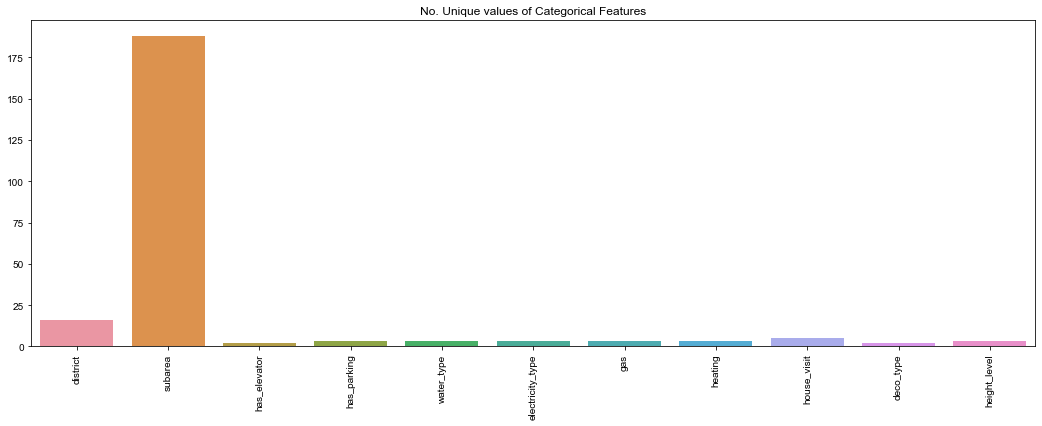

In [49]:
# Check distinc values for each categorical feature
unique_values = []
for feature in categorical_columns:
  unique_values.append(df[feature].nunique())
  print(f'{feature}: {df[feature].nunique()} unique values.')
  print()

plt.figure(figsize=(18,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=categorical_columns,y=unique_values)
plt.show()

# Exploratory data analysis

## Uni-variate analysis

### Numerical data

In [50]:
# Examing statistics of variables
df.describe()

price     area(sqm)  num_living_R     num_bed_R    num_bath_R  \
count   11541.000000  11541.000000  11541.000000  11541.000000  11541.000000   
mean     6498.297288     78.559565      2.001820      1.304740      1.209254   
std      4862.973628     43.539212      0.883851      0.567095      0.500056   
min       500.000000      7.800000      1.000000      0.000000      0.000000   
25%      4200.000000     50.300000      1.000000      1.000000      1.000000   
50%      5200.000000     72.050000      2.000000      1.000000      1.000000   
75%      7200.000000     94.460000      2.000000      2.000000      1.000000   
max    136000.000000    778.000000      9.000000      4.000000      9.000000   

        total_floor     longitude      latitude    num_Mlines  dist_to_metro  \
count  11541.000000  11541.000000  11541.000000  11541.000000   11541.000000   
mean      11.330561    121.445575     31.209115      1.449268       1.561845   
std        7.716600      0.129451      0.116376      1.638508       3.503594   
min        1.000000    120.930790     30.715358      0.000000       0.005826   
25%        6.000000    121.377435     31.149981      0.000000       0.475430   
50%        7.000000    121.449937     31.217854      1.000000       0.800041   
75%       17.000000    121.521683     31.284280      2.000000       1.480655   
max       49.000000    121.939316     31.660961     13.000000      35.495340   

       num_metro_stations_in_1km  num_facilities  
count               11541.000000    11541.000000  
mean                    1.740317        3.897756  
std                     2.218692        3.354158  
min                     0.000000        0.000000  
25%                     0.000000        0.000000  
50%                     1.000000        4.000000  
75%                     3.000000        7.000000  
max                    13.000000       10.000000

In [51]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [52]:
numerical_columns = list(df.describe().columns)
numerical_columns

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'longitude',
 'latitude',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km',
 'num_facilities']

<Figure size 1500x1500 with 0 Axes>

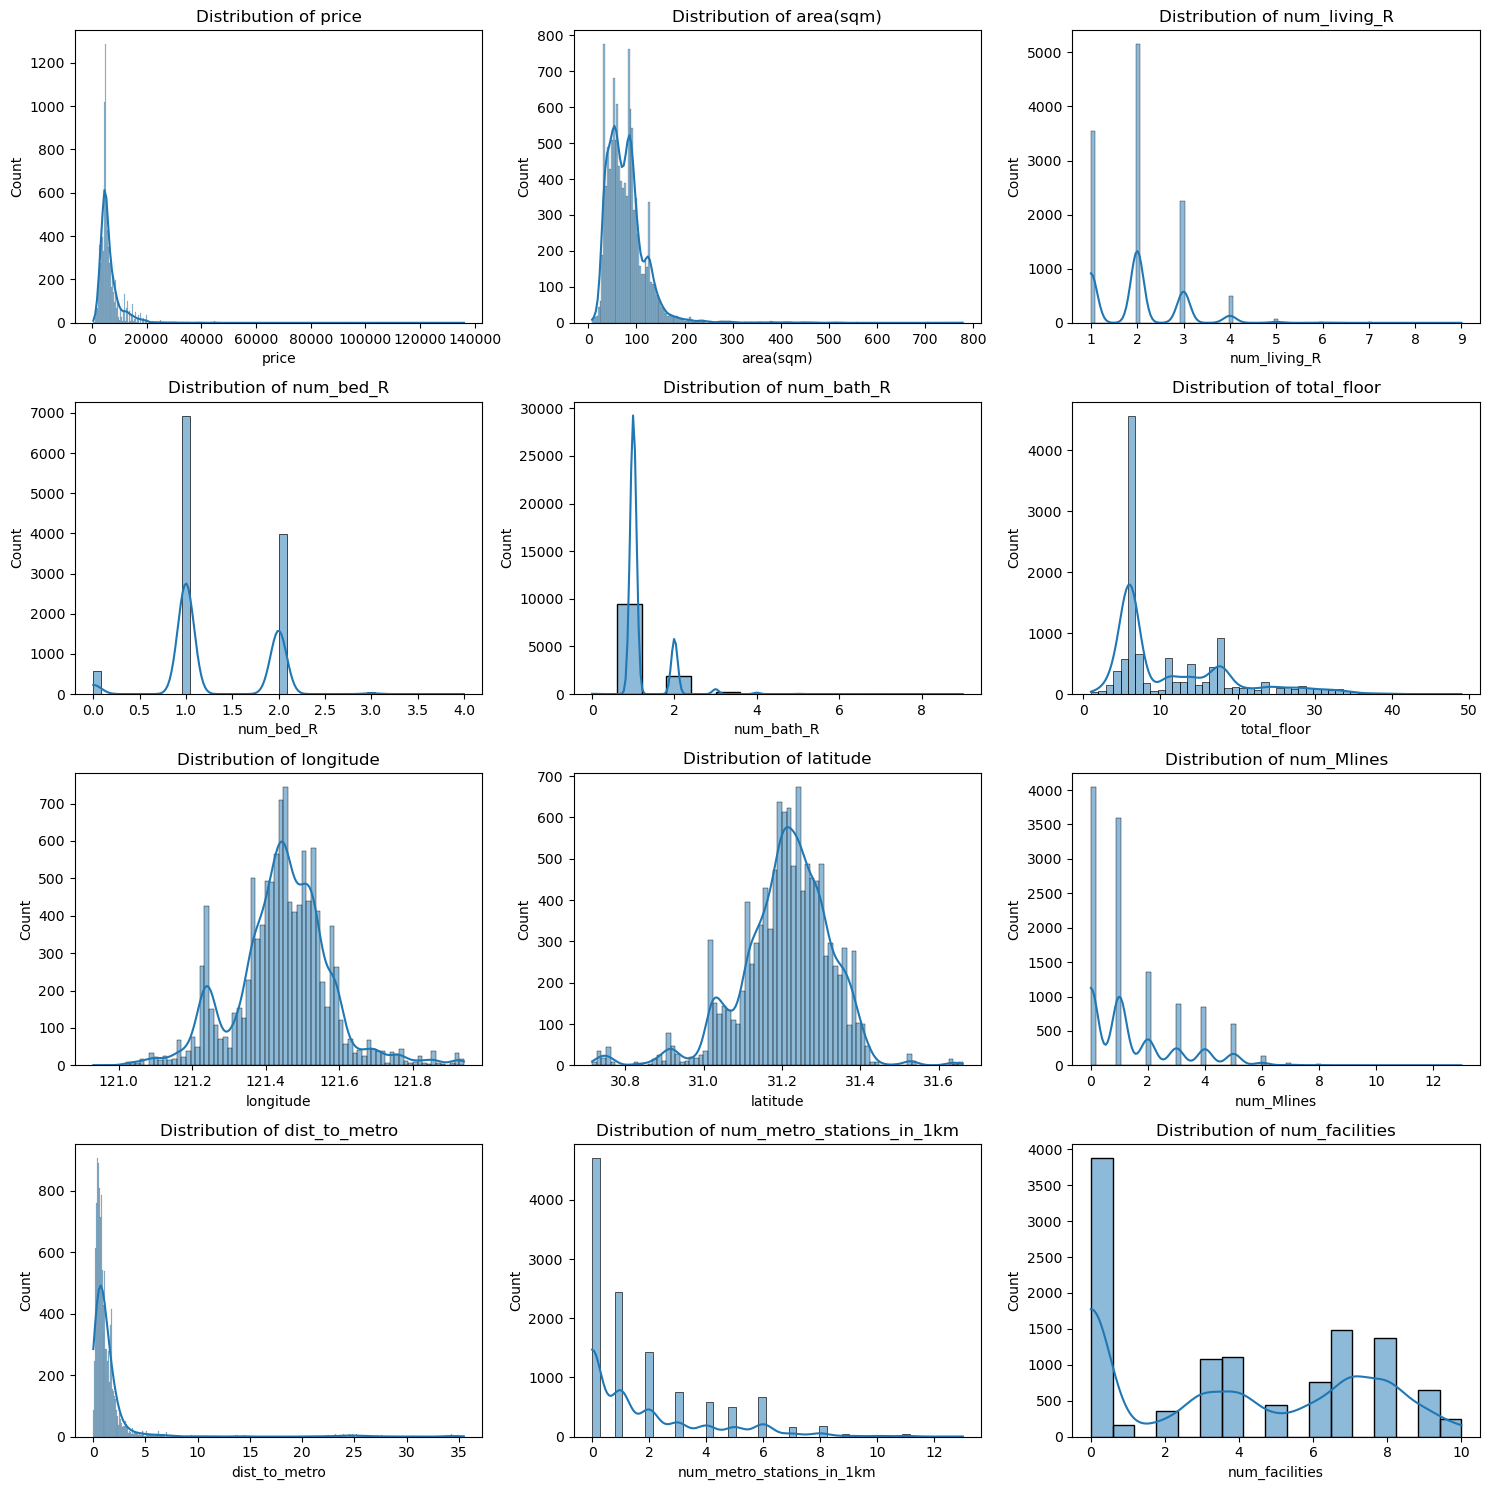

In [53]:
# Check distribution of numerical variables
plt.figure(figsize=(15, 15))

# Adjust the number of rows and columns based on your preference
num_rows = 4
num_cols = 3

f, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through numerical columns and create distribution plots
for i, feature in enumerate(numerical_columns):
    sns.histplot(data=df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

* Notably, there are discernible outliers in the continuous numerical variables `price`, `area(sqm)`.
* It's worth noting that `price` will be subsequently partitioned into the target variable.

<Figure size 1500x1500 with 0 Axes>

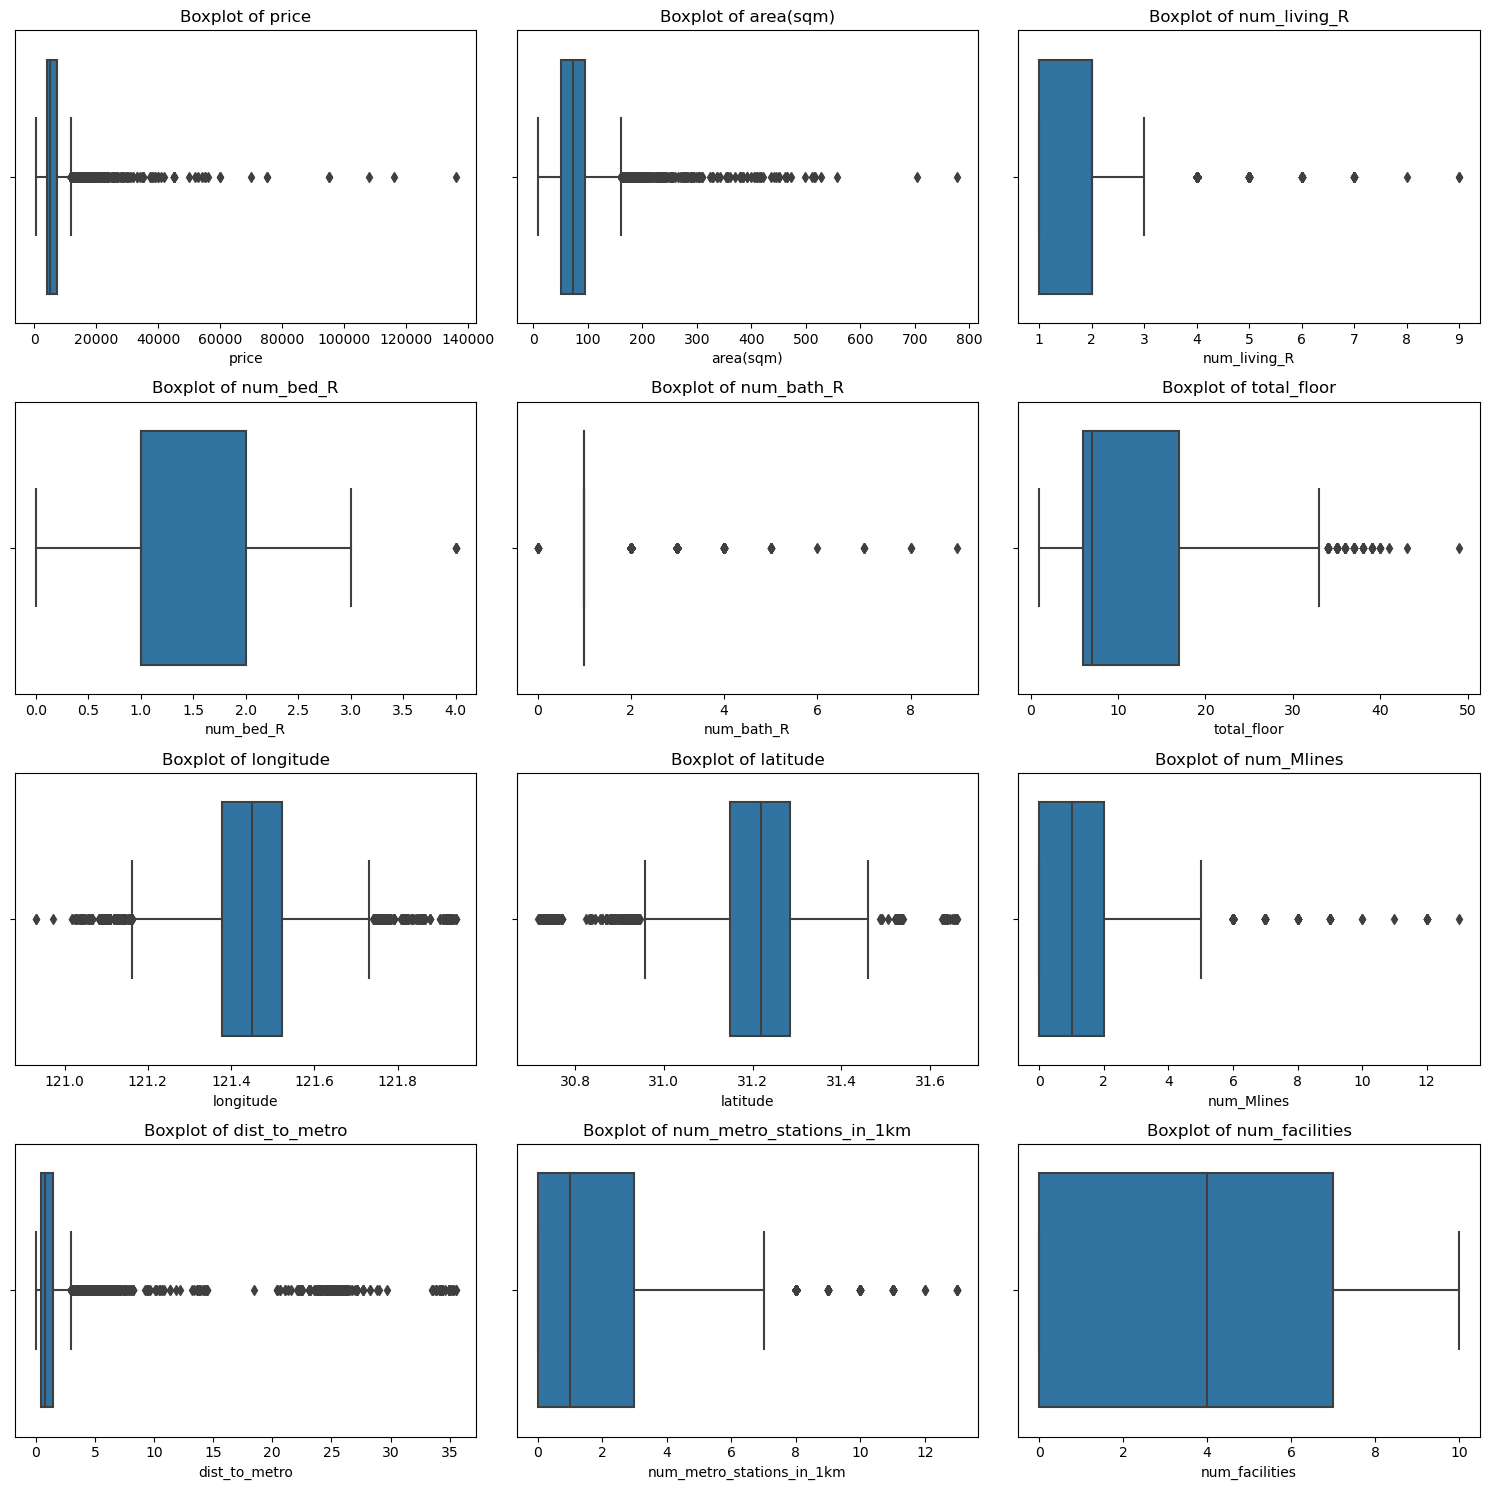

In [54]:
# Visualize the outliers

plt.figure(figsize=(15, 15))

# Adjust the number of rows and columns based on your preference
num_rows = 4
num_cols = 3

f, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through numerical columns and create boxplots
for i, feature in enumerate(numerical_columns):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

# Adjust layout to prevent overlapping
plt.tight_layout()
#plt.subplots_adjust(wspace=0.4, hspace=1)

# Show the plots
plt.show()

First I try to use the 1.5 *IQR rule to find the outliers in numerical variables.

In [55]:
# Get number of outliers in "area(sqm)" and "price" to decide if it should be deleted it

q1 = df[['area(sqm)','price', 'dist_to_metro']].quantile(0.25)
q3 = df[['area(sqm)','price', 'dist_to_metro']].quantile(0.75)
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

print(f'Lower bound:\n{lower_bound}')
print()
print(f'Upper bound:\n{upper_bound}')

Lower bound:
area(sqm)        -15.940000
price           -300.000000
dist_to_metro     -1.032409
dtype: float64

Upper bound:
area(sqm)          160.700000
price            11700.000000
dist_to_metro        2.988494
dtype: float64


In [56]:
# Identify the outliers in each column
outliers = pd.DataFrame()
for col in df[['area(sqm)','price', 'dist_to_metro']].columns:
    outliers[col] = (df[col] < lower_bound[col]) | (df[col] > upper_bound[col])
    num_outliers = outliers[col].sum()
# print the outliers
#outliers
    print(f'"{col}" feature has {outliers[col].sum()} outliers, making up {(num_outliers/len(df))*100:.2f}% of the total records.')

"area(sqm)" feature has 339 outliers, making up 2.94% of the total records.
"price" feature has 1078 outliers, making up 9.34% of the total records.
"dist_to_metro" feature has 770 outliers, making up 6.67% of the total records.


* It appears that the upper bounds for `area (sqm)`, `price` and `dist_to_metro` are still within reasonable ranges.
* Considering that outright removal of all outliers could result in the loss of valuable information, let's explore alternative techniques for handling outliers.

# Determine the value at which the data encompasses 99% of the total, ensuring the retention of a substantial amount of information

column_name = ['area(sqm)','price', 'dist_to_metro']

# Calculate the 97th percentile value
percentile_97 = df[column_name].quantile(0.995)
percentile_97

In [57]:
# Drop rows based on "area" condition
df.drop(df[df['area(sqm)'] > 160.700000].index, inplace=True)
df

district subarea  price  area(sqm) has_elevator has_parking water_type  \
1           徐汇      龙华   6300      33.06            无        暂无数据         民水   
2           嘉定    嘉定老城   2800      82.90            无        暂无数据         民水   
3           静安     曹家渡   2900      22.80            无        暂无数据       暂无数据   
4           静安      大宁   3000      37.71            无        租用车位         民水   
5           静安      彭浦   3000      40.42            无        暂无数据         民水   
...        ...     ...    ...        ...          ...         ...        ...   
12517       嘉定    嘉定老城   2800      82.90            无        暂无数据         民水   
12518       徐汇      龙华   6300      33.06            无        暂无数据         民水   
12519       嘉定    嘉定老城   2800      82.90            无        暂无数据         民水   
12520       徐汇      龙华   6300      33.06            无        暂无数据         民水   
12521       嘉定    嘉定老城   2800      82.90            无        暂无数据         民水   

      electricity_type gas heating  ... height_level  total_floor   longitude  \
1                   民电   有     自采暖  ...            中            4  121.458558   
2                   民电   有     自采暖  ...            高            6  121.244739   
3                 暂无数据   有     自采暖  ...            中            5  121.440150   
4                   民电   有     自采暖  ...            高            6  121.456775   
5                   民电   有     自采暖  ...            高            6  121.443627   
...                ...  ..     ...  ...          ...          ...         ...   
12517               民电   有     自采暖  ...            高            6  121.244739   
12518               民电   有     自采暖  ...            中            4  121.458558   
12519               民电   有     自采暖  ...            高            6  121.244739   
12520               民电   有     自采暖  ...            中            4  121.458558   
12521               民电   有     自采暖  ...            高            6  121.244739   

        latitude num_Mlines dist_to_metro  num_metro_stations_in_1km  \
1      31.190578          4      0.408018                          6   
2      31.378085          0      1.707796                          0   
3      31.233024          5      0.285941                          4   
4      31.280534          1      0.533154                          2   
5      31.316021          0      0.501036                          1   
...          ...        ...           ...                        ...   
12517  31.378085          0      1.707796                          0   
12518  31.190578          4      0.408018                          6   
12519  31.378085          0      1.707796                          0   
12520  31.190578          4      0.408018                          6   
12521  31.378085          0      1.707796                          0   

       num_facilities  south   east  
1                   4   True  False  
2                   0   True  False  
3                   7   True  False  
4                   8   True  False  
5                   4   True  False  
...               ...    ...    ...  
12517               0   True  False  
12518               4   True  False  
12519               0   True  False  
12520               4   True  False  
12521               0   True  False  

[11202 rows x 25 columns]

In [58]:
# Check the range of "area(sqm)"
df.sort_values('area(sqm)', ascending=False)

district subarea  price  area(sqm) has_elevator has_parking water_type  \
10866       嘉定      安亭   5300     160.52            有        租用车位         民水   
11983       松江    莘闵别墅   8300     160.42            有        暂无数据         民水   
1988        黄浦    蓬莱公园  17000     160.34            有        暂无数据         民水   
3995        浦东      宣桥   4200     160.15            有        租用车位         民水   
5822        浦东      杨东  15600     160.00            有        租用车位         民水   
...        ...     ...    ...        ...          ...         ...        ...   
2029        黄浦    南京东路   7000       9.40            有        暂无数据       暂无数据   
1973        黄浦    淮海中路   2900       9.00            无        暂无数据       暂无数据   
7           静安    南京西路   2200       8.90            无        暂无数据         民水   
810         徐汇     衡山路   2800       7.90            无        暂无数据       暂无数据   
56          静安    南京西路   4200       7.80            无        暂无数据         民水   

      electricity_type   gas heating  ... height_level  total_floor  \
10866               民电     无    暂无数据  ...            低           18   
11983               民电     有     自采暖  ...            低           14   
1988                民电     有     自采暖  ...            中           26   
3995                民电     有     自采暖  ...            低           18   
5822                民电     有     自采暖  ...            低           12   
...                ...   ...     ...  ...          ...          ...   
2029              暂无数据  暂无数据    暂无数据  ...            低            7   
1973              暂无数据     无     自采暖  ...            高            3   
7                   民电     有     自采暖  ...            低            4   
810               暂无数据     无    暂无数据  ...            低            4   
56                  民电     无    暂无数据  ...            低            3   

        longitude   latitude num_Mlines dist_to_metro  \
10866  121.218841  31.286585          0      2.196397   
11983  121.353117  31.105887          0      3.045642   
1988   121.491812  31.214569          4      0.704876   
3995   121.715747  31.067346          0      2.638209   
5822   121.545150  31.215325          0      0.396586   
...           ...        ...        ...           ...   
2029   121.492935  31.239281          5      0.932969   
1973   121.469122  31.214095          8      0.719643   
7      121.472081  31.236822          5      0.469771   
810    121.453003  31.207153          5      0.787626   
56     121.463004  31.232786          5      0.413658   

       num_metro_stations_in_1km  num_facilities  south   east  
10866                          0               0   True  False  
11983                          0               0   True  False  
1988                           3               8   True  False  
3995                           0               9   True  False  
5822                           3               8   True  False  
...                          ...             ...    ...    ...  
2029                           3               2   True   True  
1973                           5               6  False  False  
7                              6               4   True  False  
810                            9               0   True  False  
56                             5               0   True  False  

[11202 rows x 25 columns]

In [59]:
# Check the range of "price"
df.sort_values('price', ascending=False)

district subarea  price  area(sqm) has_elevator has_parking water_type  \
1784        黄浦    蓬莱公园  45000     150.00            有        租用车位         民水   
1771        黄浦     老西门  40000     136.83            有        暂无数据         民水   
1793        黄浦      豫园  37500     140.00            无        租用车位       暂无数据   
1833        黄浦      豫园  35000     154.19            无        免费使用       暂无数据   
7479        虹口     临平路  35000     155.99            有        租用车位       暂无数据   
...        ...     ...    ...        ...          ...         ...        ...   
11023       崇明     陈家镇    500      85.00            无        暂无数据         民水   
11041       崇明     陈家镇    500      85.00            无        暂无数据         民水   
11049       崇明     陈家镇    500      88.00            无        暂无数据         民水   
10984       崇明     陈家镇    500      87.00            无        租用车位       暂无数据   
10978       崇明     陈家镇    500      85.00            无        暂无数据         民水   

      electricity_type   gas heating  ... height_level  total_floor  \
1784                民电     有     自采暖  ...            高           23   
1771                民电     有     自采暖  ...            低           35   
1793              暂无数据  暂无数据    暂无数据  ...            低            3   
1833              暂无数据  暂无数据    暂无数据  ...            低           17   
7479              暂无数据     有    集中供暖  ...            中           35   
...                ...   ...     ...  ...          ...          ...   
11023               民电     无    暂无数据  ...            高            6   
11041               民电     无    暂无数据  ...            高            6   
11049               民电     无    暂无数据  ...            中            6   
10984             暂无数据  暂无数据    暂无数据  ...            高            6   
10978               民电     无    暂无数据  ...            高            6   

        longitude   latitude num_Mlines dist_to_metro  \
1784   121.498401  31.215032          5      0.203932   
1771   121.491404  31.223154          0      0.697580   
1793   121.491330  31.229559          5      0.467221   
1833   121.497555  31.229268          3      1.121671   
7479   121.501758  31.273722          3      0.132217   
...           ...        ...        ...           ...   
11023  121.856249  31.525303          0     34.178881   
11041  121.856249  31.525303          0     34.178881   
11049  121.859650  31.524221          0     34.294562   
10984  121.852667  31.539592          0     35.288774   
10978  121.856249  31.525303          0     34.178881   

       num_metro_stations_in_1km  num_facilities  south   east  
1784                           2               3   True  False  
1771                           6               0   True  False  
1793                           3               2   True  False  
1833                           0               6   True  False  
7479                           4               9   True  False  
...                          ...             ...    ...    ...  
11023                          0               0   True  False  
11041                          0               0   True  False  
11049                          0               0   True  False  
10984                          0               0  False   True  
10978                          0               0   True  False  

[11202 rows x 25 columns]

In [60]:
# Check the range of "price"
df.sort_values('dist_to_metro', ascending=False)

district subarea  price  area(sqm) has_elevator has_parking water_type  \
11022       崇明     陈家镇   2500     119.00            无        免费使用         民水   
11043       崇明     陈家镇   2100      98.00            无        暂无数据       暂无数据   
10984       崇明     陈家镇    500      87.00            无        租用车位       暂无数据   
10997       崇明     陈家镇   2000      85.75            无        免费使用       暂无数据   
11042       崇明     陈家镇   1500      94.00            无        免费使用       暂无数据   
...        ...     ...    ...        ...          ...         ...        ...   
8196        杨浦    周家嘴路   7000      65.91            有        暂无数据         民水   
1921        黄浦     新天地   6200      22.20            无        暂无数据         民水   
1874        黄浦     新天地   6200      22.20            无        暂无数据         民水   
5228        浦东      金杨   7800      73.80            无        暂无数据         民水   
4944        浦东      金杨   6200      76.62            无        暂无数据         民水   

      electricity_type   gas heating  ... height_level  total_floor  \
11022               民电     无    暂无数据  ...            中           10   
11043             暂无数据  暂无数据    暂无数据  ...            中           10   
10984             暂无数据  暂无数据    暂无数据  ...            高            6   
10997             暂无数据  暂无数据    暂无数据  ...            高            6   
11042             暂无数据  暂无数据    暂无数据  ...            中            6   
...                ...   ...     ...  ...          ...          ...   
8196                民电     有     自采暖  ...            低           34   
1921                民电     有     自采暖  ...            高            3   
1874                民电     有     自采暖  ...            高            3   
5228                民电     有    暂无数据  ...            低            7   
4944                民电     有    暂无数据  ...            中            7   

        longitude   latitude num_Mlines dist_to_metro  \
11022  121.866288  31.532757          0     35.495340   
11043  121.866288  31.532757          0     35.495340   
10984  121.852667  31.539592          0     35.288774   
10997  121.858957  31.535486          0     35.286278   
11042  121.858957  31.535486          0     35.286278   
...           ...        ...        ...           ...   
8196   121.544729  31.275021          1      0.021786   
1921   121.479186  31.227278          5      0.012707   
1874   121.479186  31.227278          5      0.012707   
5228   121.571141  31.251020          2      0.005826   
4944   121.571141  31.251020          2      0.005826   

       num_metro_stations_in_1km  num_facilities  south   east  
11022                          0               0   True  False  
11043                          0               0   True  False  
10984                          0               0  False   True  
10997                          0               8   True  False  
11042                          0               8   True  False  
...                          ...             ...    ...    ...  
8196                           1               0   True  False  
1921                          10               0   True  False  
1874                          10               0   True  False  
5228                           3               2   True  False  
4944                           3               3   True  False  

[11202 rows x 25 columns]

<Figure size 1500x1500 with 0 Axes>

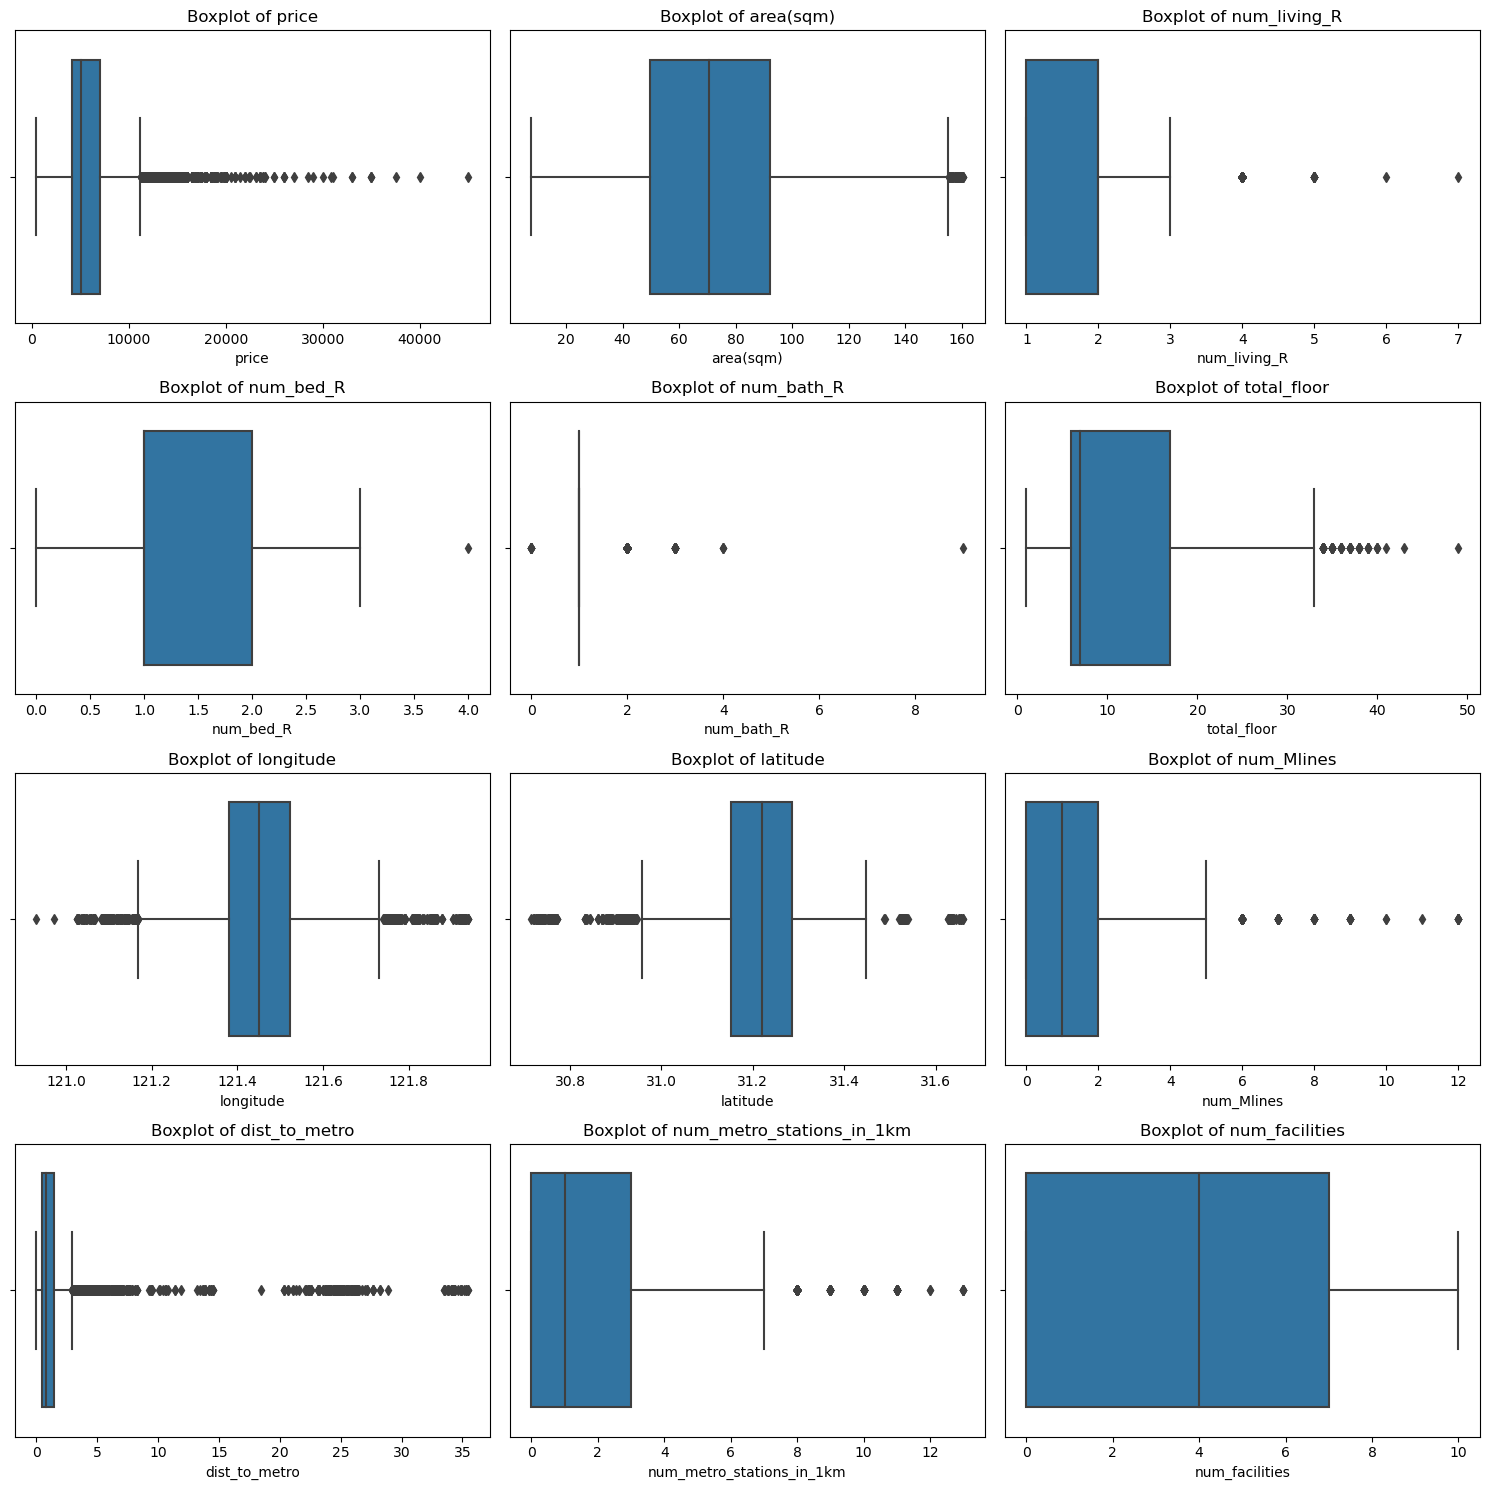

In [61]:
# Visualize the outliers again

plt.figure(figsize=(15, 15))

# Adjust the number of rows and columns based on your preference
num_rows = 4
num_cols = 3

f, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through numerical columns and create boxplots
for i, feature in enumerate(numerical_columns):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

# Adjust layout to prevent overlapping
plt.tight_layout()
#plt.subplots_adjust(wspace=0.4, hspace=1)

# Show the plots
plt.show()

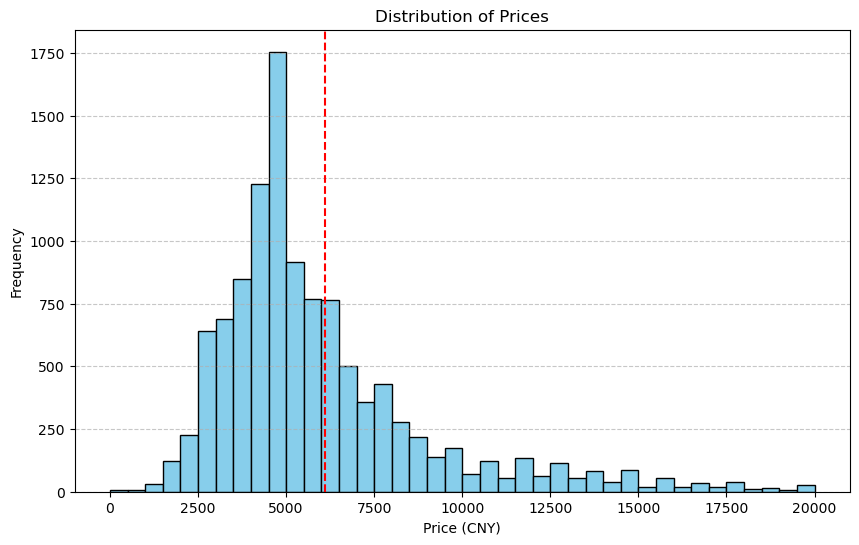

In [62]:
# Visualize the distribution of prices with a histogram
plt.figure(figsize=(10, 6))
df["price"].plot(kind='hist', bins=40, range=(1, 20000), edgecolor='black', color='skyblue')
plt.title('Distribution of Prices')
plt.xlabel('Price (CNY)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(df['price'].mean(), color='r', ls='--');
plt.show()

* We can see that most of the rental price are between 4500CNY and 500CNY.
* The acerage rental price is 6300CNY.
* The mean is greater than the mode, which indicates that the distribution of values is skewed to the right.
* Most of the values are concentrated on the left side (lower values), and fewer values extend towards the right side (higher values).
* The mean is influenced by the presence of higher values in the right tail, pulling it towards higher values.



### Categorical data

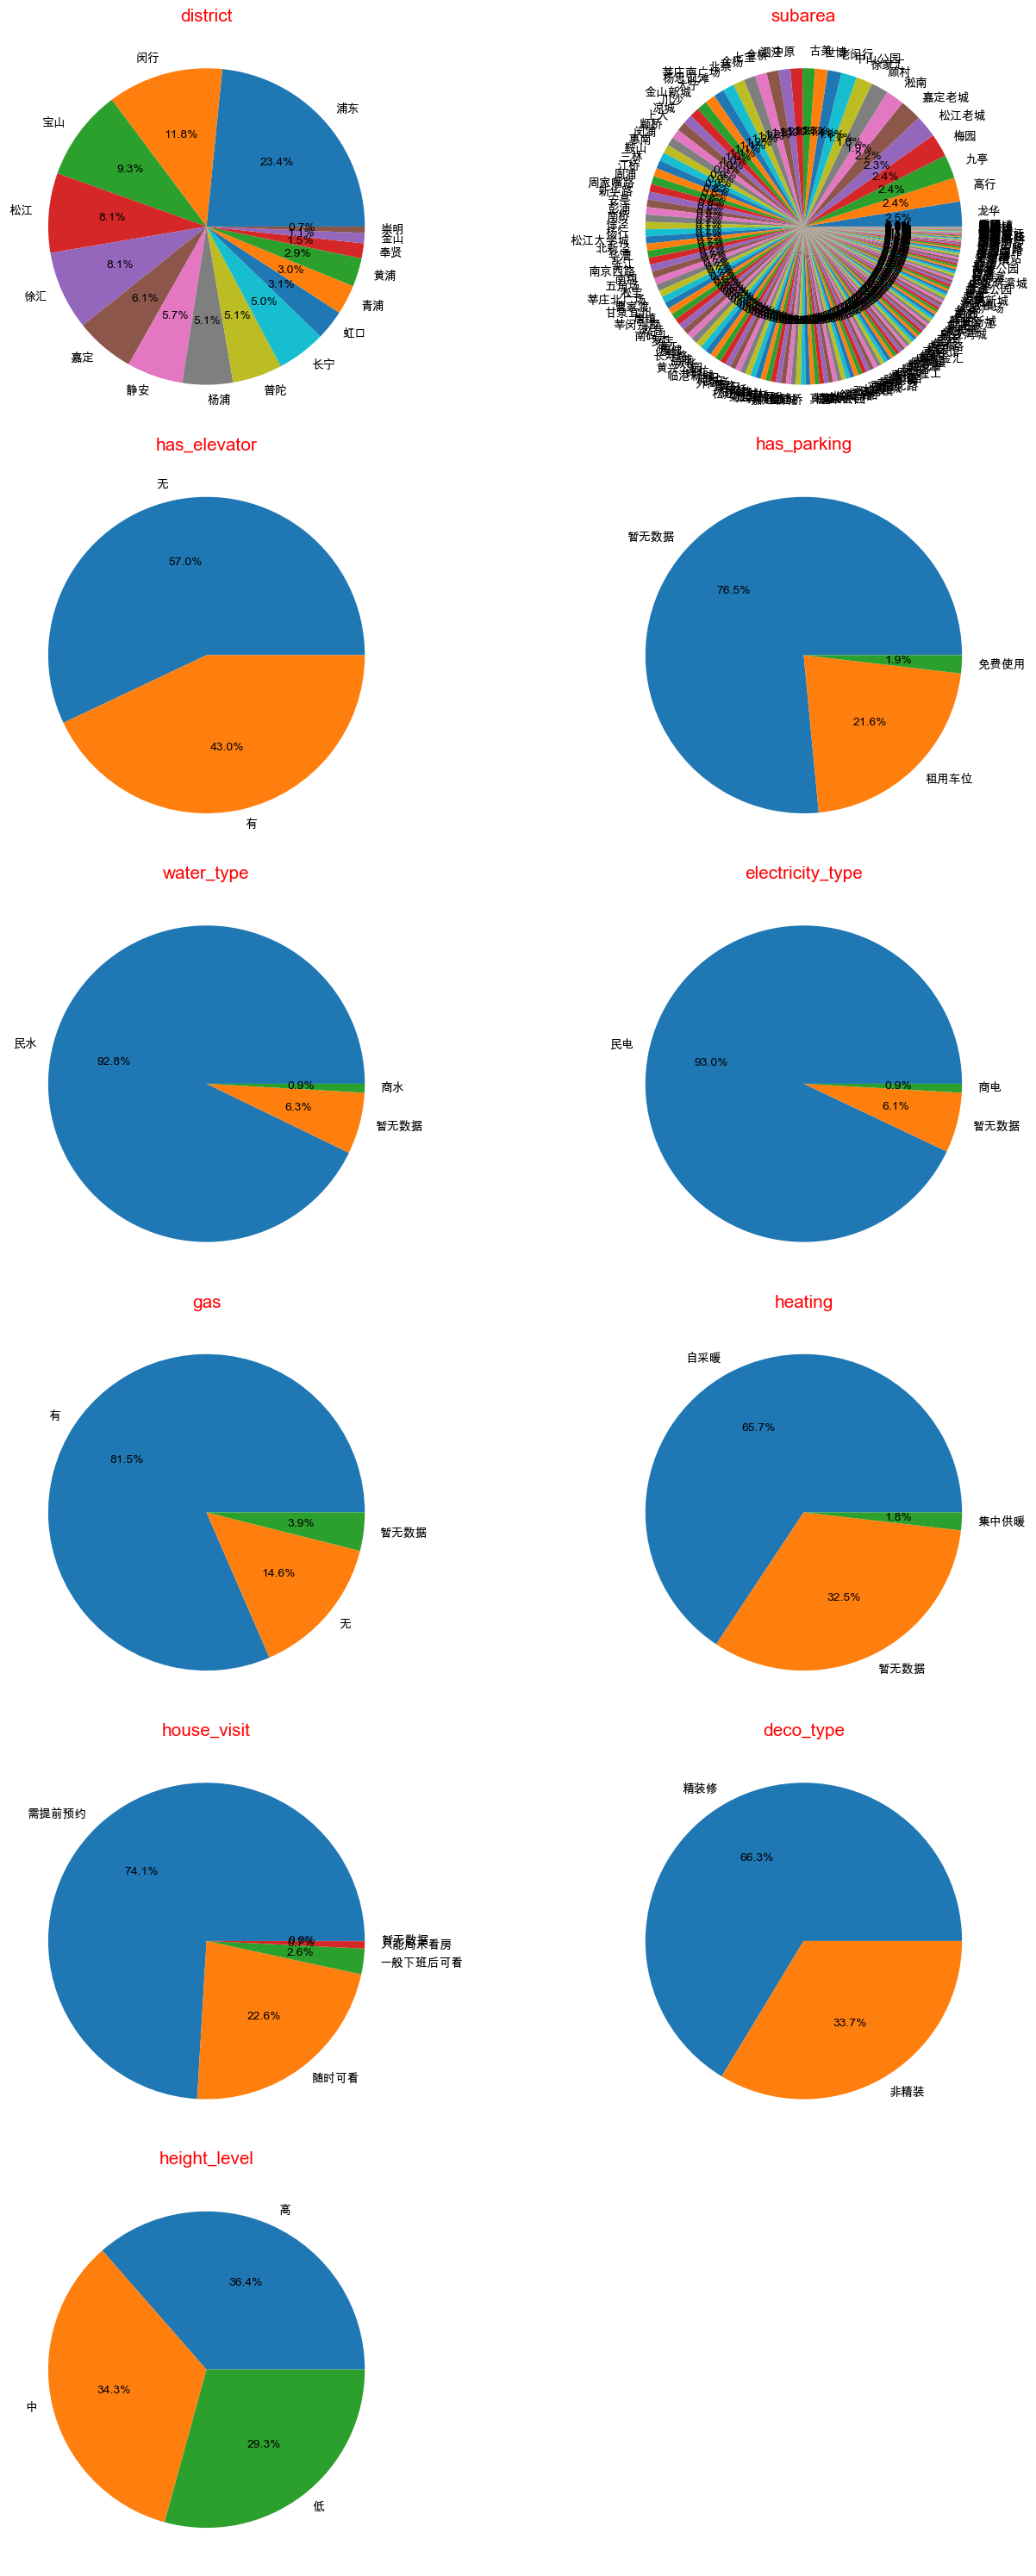

In [63]:
# Visualize distribution of categorical variables

# To plot Chinese characters correctly
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.figure(figsize=(15, 30))

num_rows = 6
num_cols = 2

for i, v in enumerate(categorical_columns):
  # Create subplots
  plt.subplot(num_rows, num_cols, i+1)

  # Create pie chart with explicit labels
  observation_value = list(df[v].value_counts().index)
  observation_count = list(df[v].value_counts())
  plt.pie(observation_count, labels=observation_value, autopct='%1.1f%%')

  # Set title and legend
  plt.title(f'{v}', color='r', fontsize=15, weight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

## Bivariate analysis

### Numerical relation

In [64]:
numerical_columns

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'longitude',
 'latitude',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km',
 'num_facilities']

In [65]:
numerical_axis_name = ['Rental price',
                       'Total area in square meter',
                       'Number of living rooms',
                       'Number of bed rooms',
                       'Number of bath rooms',
                       'Number of metro line nearby',
                       'Number of facilities provided']

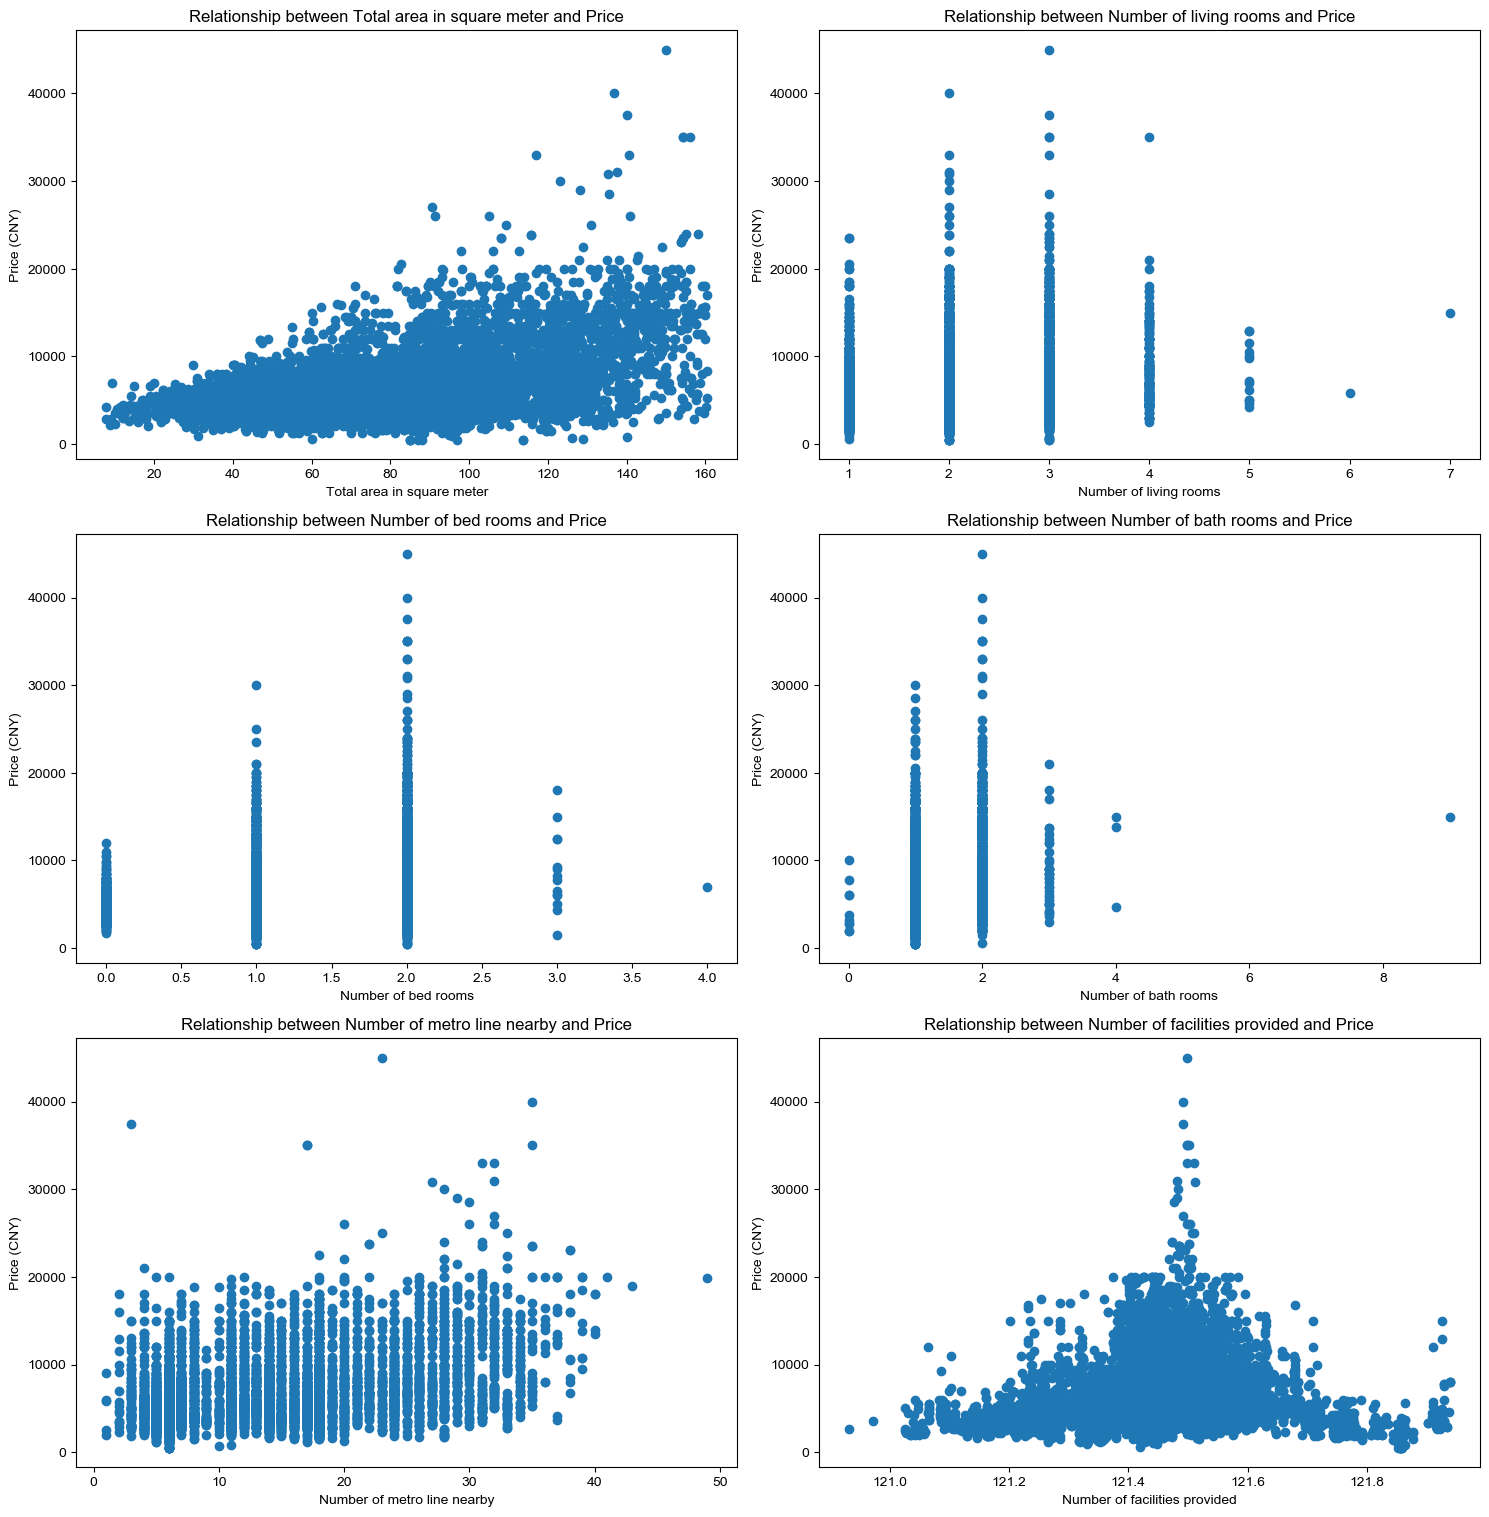

In [66]:
# Visualize relation between numerical variables and target price
plt.figure(figsize=(15, 30))

num_rows = 6
num_cols = 2

numerical_columns_and_names = list(zip(numerical_columns, numerical_axis_name))[1:]

for i, (column, name) in enumerate(numerical_columns_and_names):
    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)

    plt.scatter(df[column], df['price'])
    plt.xlabel(name)
    plt.ylabel('Price (CNY)')
    plt.title(f'Relationship between {name} and Price')

# Adjust layout
plt.tight_layout()
plt.show()

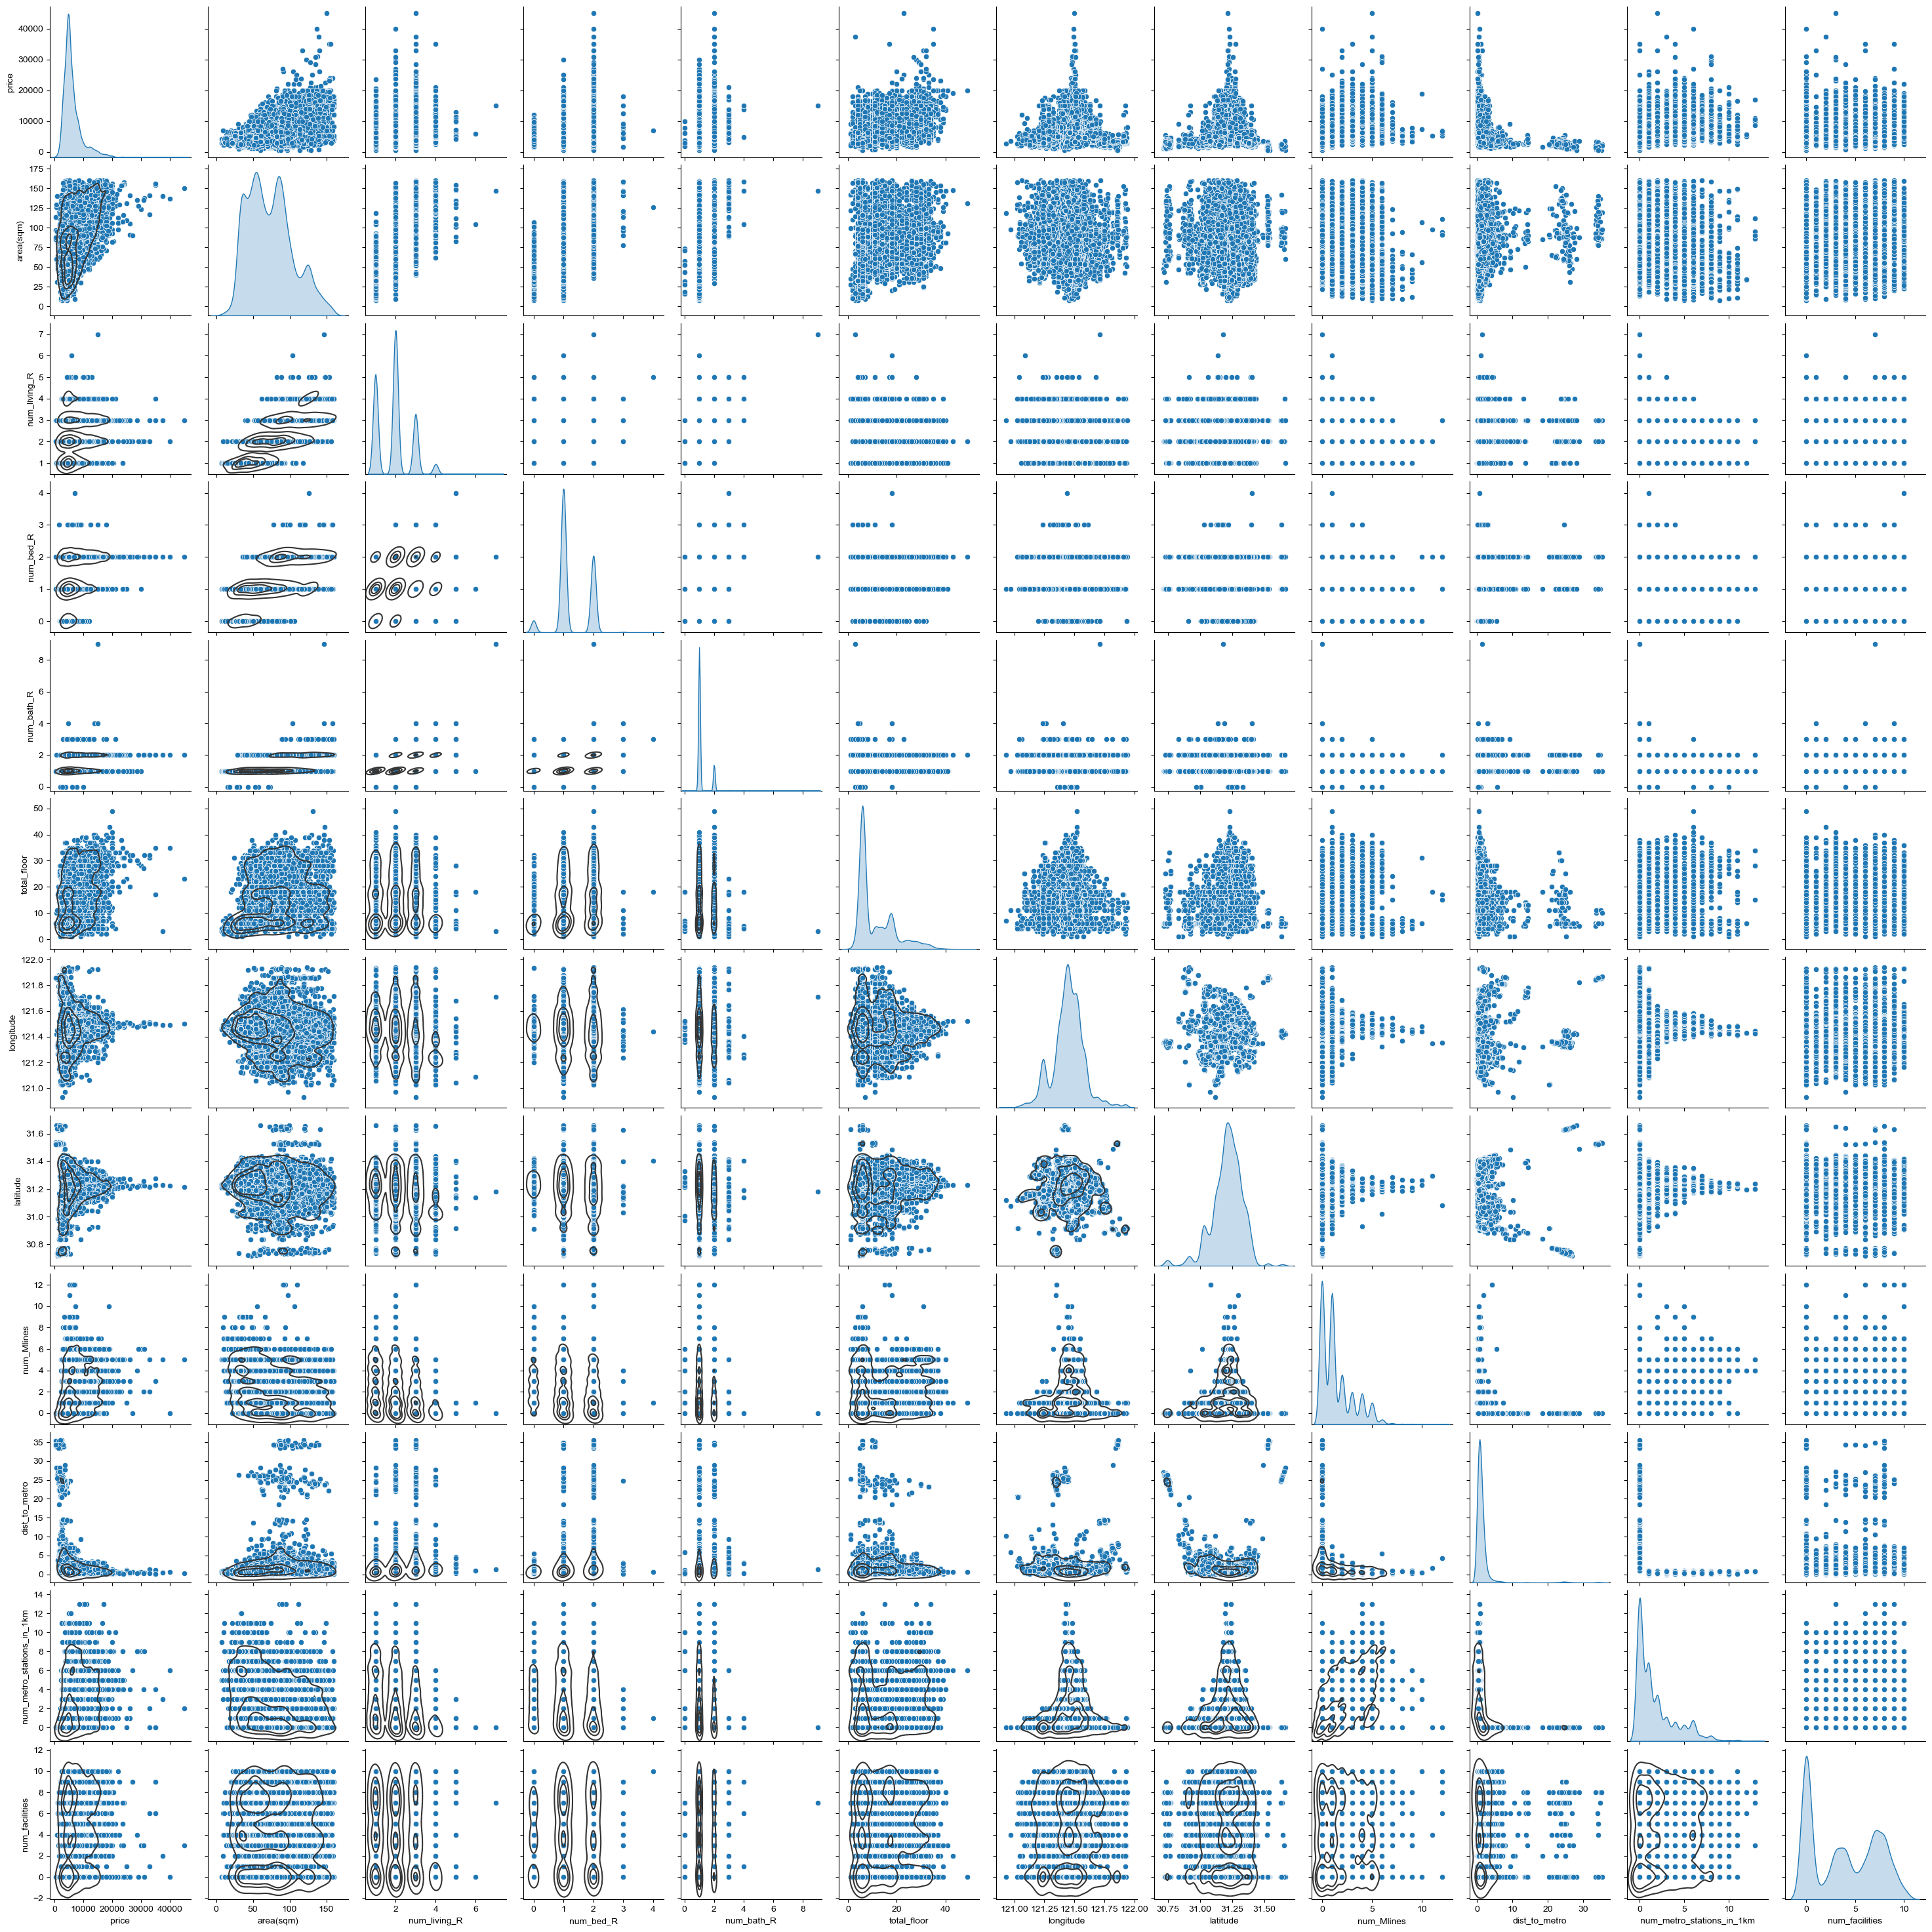

In [67]:
# Examining numeric variables among themselves(analysis with pair plot)
g = sns.pairplot(df[numerical_columns], diag_kind='kde')
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

In [68]:
# Correlations between numerical variables
df[numerical_columns].corr()

price  area(sqm)  num_living_R  num_bed_R  \
price                      1.000000   0.477348      0.272756   0.315361   
area(sqm)                  0.477348   1.000000      0.797414   0.653120   
num_living_R               0.272756   0.797414      1.000000   0.438451   
num_bed_R                  0.315361   0.653120      0.438451   1.000000   
num_bath_R                 0.326011   0.600759      0.544659   0.398350   
total_floor                0.425028   0.330406      0.107110   0.235419   
longitude                  0.092075  -0.155816     -0.194899  -0.118410   
latitude                   0.059498  -0.151841     -0.161474  -0.083265   
num_Mlines                 0.306756  -0.291421     -0.276666  -0.222055   
dist_to_metro             -0.215639   0.151315      0.137633   0.143595   
num_metro_stations_in_1km  0.325804  -0.255607     -0.260451  -0.222338   
num_facilities             0.082672  -0.080888     -0.093554  -0.065170   

                           num_bath_R  total_floor  longitude  latitude  \
price                        0.326011     0.425028   0.092075  0.059498   
area(sqm)                    0.600759     0.330406  -0.155816 -0.151841   
num_living_R                 0.544659     0.107110  -0.194899 -0.161474   
num_bed_R                    0.398350     0.235419  -0.118410 -0.083265   
num_bath_R                   1.000000     0.084117  -0.137613 -0.185683   
total_floor                  0.084117     1.000000  -0.015021  0.010174   
longitude                   -0.137613    -0.015021   1.000000  0.060027   
latitude                    -0.185683     0.010174   0.060027  1.000000   
num_Mlines                  -0.120579     0.033482   0.130411  0.096436   
dist_to_metro                0.057528    -0.021279   0.020650 -0.180242   
num_metro_stations_in_1km   -0.131427     0.052520   0.124949  0.078239   
num_facilities              -0.078835     0.048021   0.118992  0.044583   

                           num_Mlines  dist_to_metro  \
price                        0.306756      -0.215639   
area(sqm)                   -0.291421       0.151315   
num_living_R                -0.276666       0.137633   
num_bed_R                   -0.222055       0.143595   
num_bath_R                  -0.120579       0.057528   
total_floor                  0.033482      -0.021279   
longitude                    0.130411       0.020650   
latitude                     0.096436      -0.180242   
num_Mlines                   1.000000      -0.229650   
dist_to_metro               -0.229650       1.000000   
num_metro_stations_in_1km    0.666975      -0.234861   
num_facilities               0.036788      -0.066083   

                           num_metro_stations_in_1km  num_facilities  
price                                       0.325804        0.082672  
area(sqm)                                  -0.255607       -0.080888  
num_living_R                               -0.260451       -0.093554  
num_bed_R                                  -0.222338       -0.065170  
num_bath_R                                 -0.131427       -0.078835  
total_floor                                 0.052520        0.048021  
longitude                                   0.124949        0.118992  
latitude                                    0.078239        0.044583  
num_Mlines                                  0.666975        0.036788  
dist_to_metro                              -0.234861       -0.066083  
num_metro_stations_in_1km                   1.000000        0.092060  
num_facilities                              0.092060        1.000000

In [69]:
# Correlation between "price" and all other numerical variable
df[numerical_columns].corr().iloc[:, [0]]

price
price                      1.000000
area(sqm)                  0.477348
num_living_R               0.272756
num_bed_R                  0.315361
num_bath_R                 0.326011
total_floor                0.425028
longitude                  0.092075
latitude                   0.059498
num_Mlines                 0.306756
dist_to_metro             -0.215639
num_metro_stations_in_1km  0.325804
num_facilities             0.082672

### Categorical-numerical relation

In [70]:
categorical_columns

['district',
 'subarea',
 'has_elevator',
 'has_parking',
 'water_type',
 'electricity_type',
 'gas',
 'heating',
 'house_visit',
 'deco_type',
 'height_level']

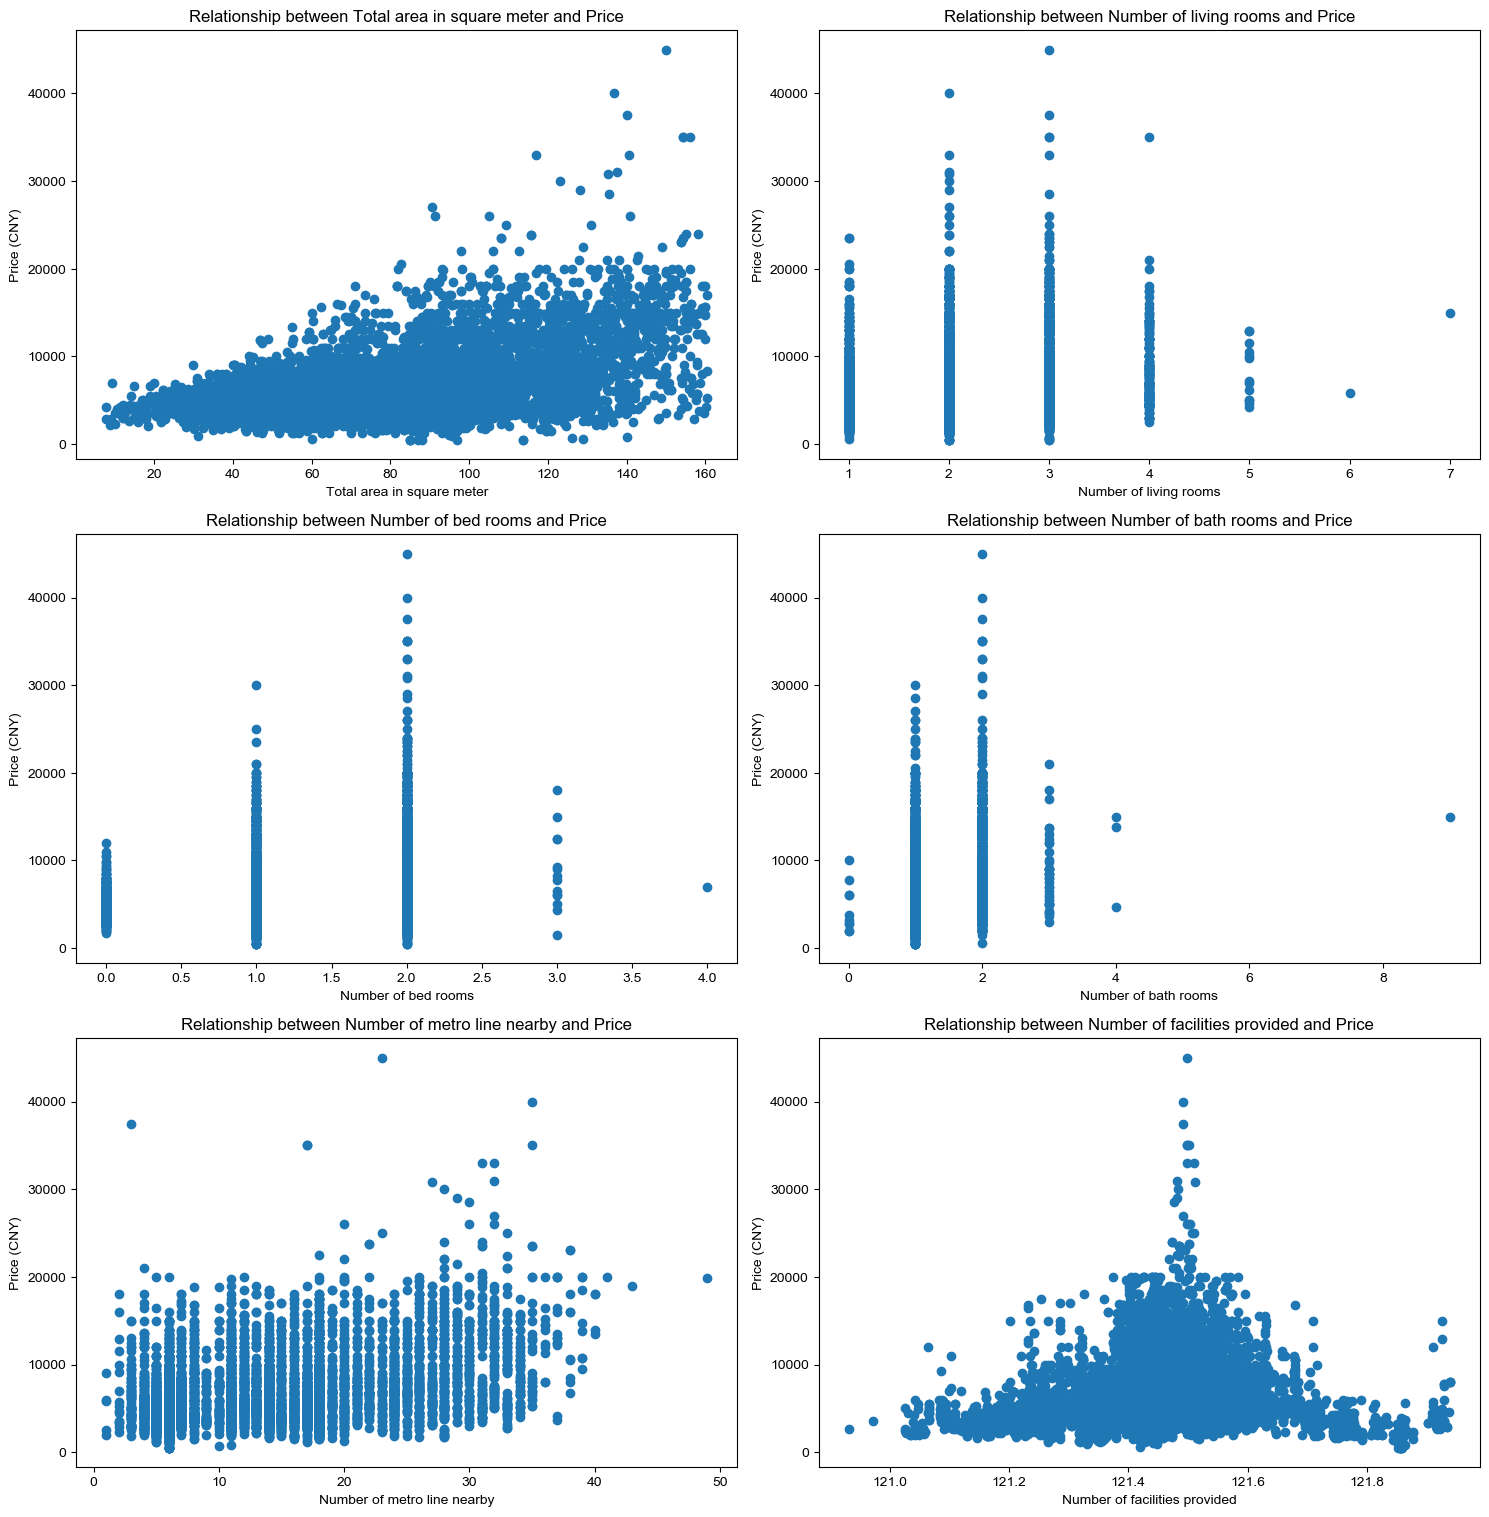

In [71]:
# Visualize relation between numerical variables
plt.figure(figsize=(15, 30))

num_rows = 6
num_cols = 2

numerical_columns_and_names = list(zip(numerical_columns, numerical_axis_name))[1:]

for i, (column, name) in enumerate(numerical_columns_and_names):
    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)

    plt.scatter(df[column], df['price'])
    plt.xlabel(name)
    plt.ylabel('Price (CNY)')
    plt.title(f'Relationship between {name} and Price')

# Adjust layout
plt.tight_layout()
plt.show()

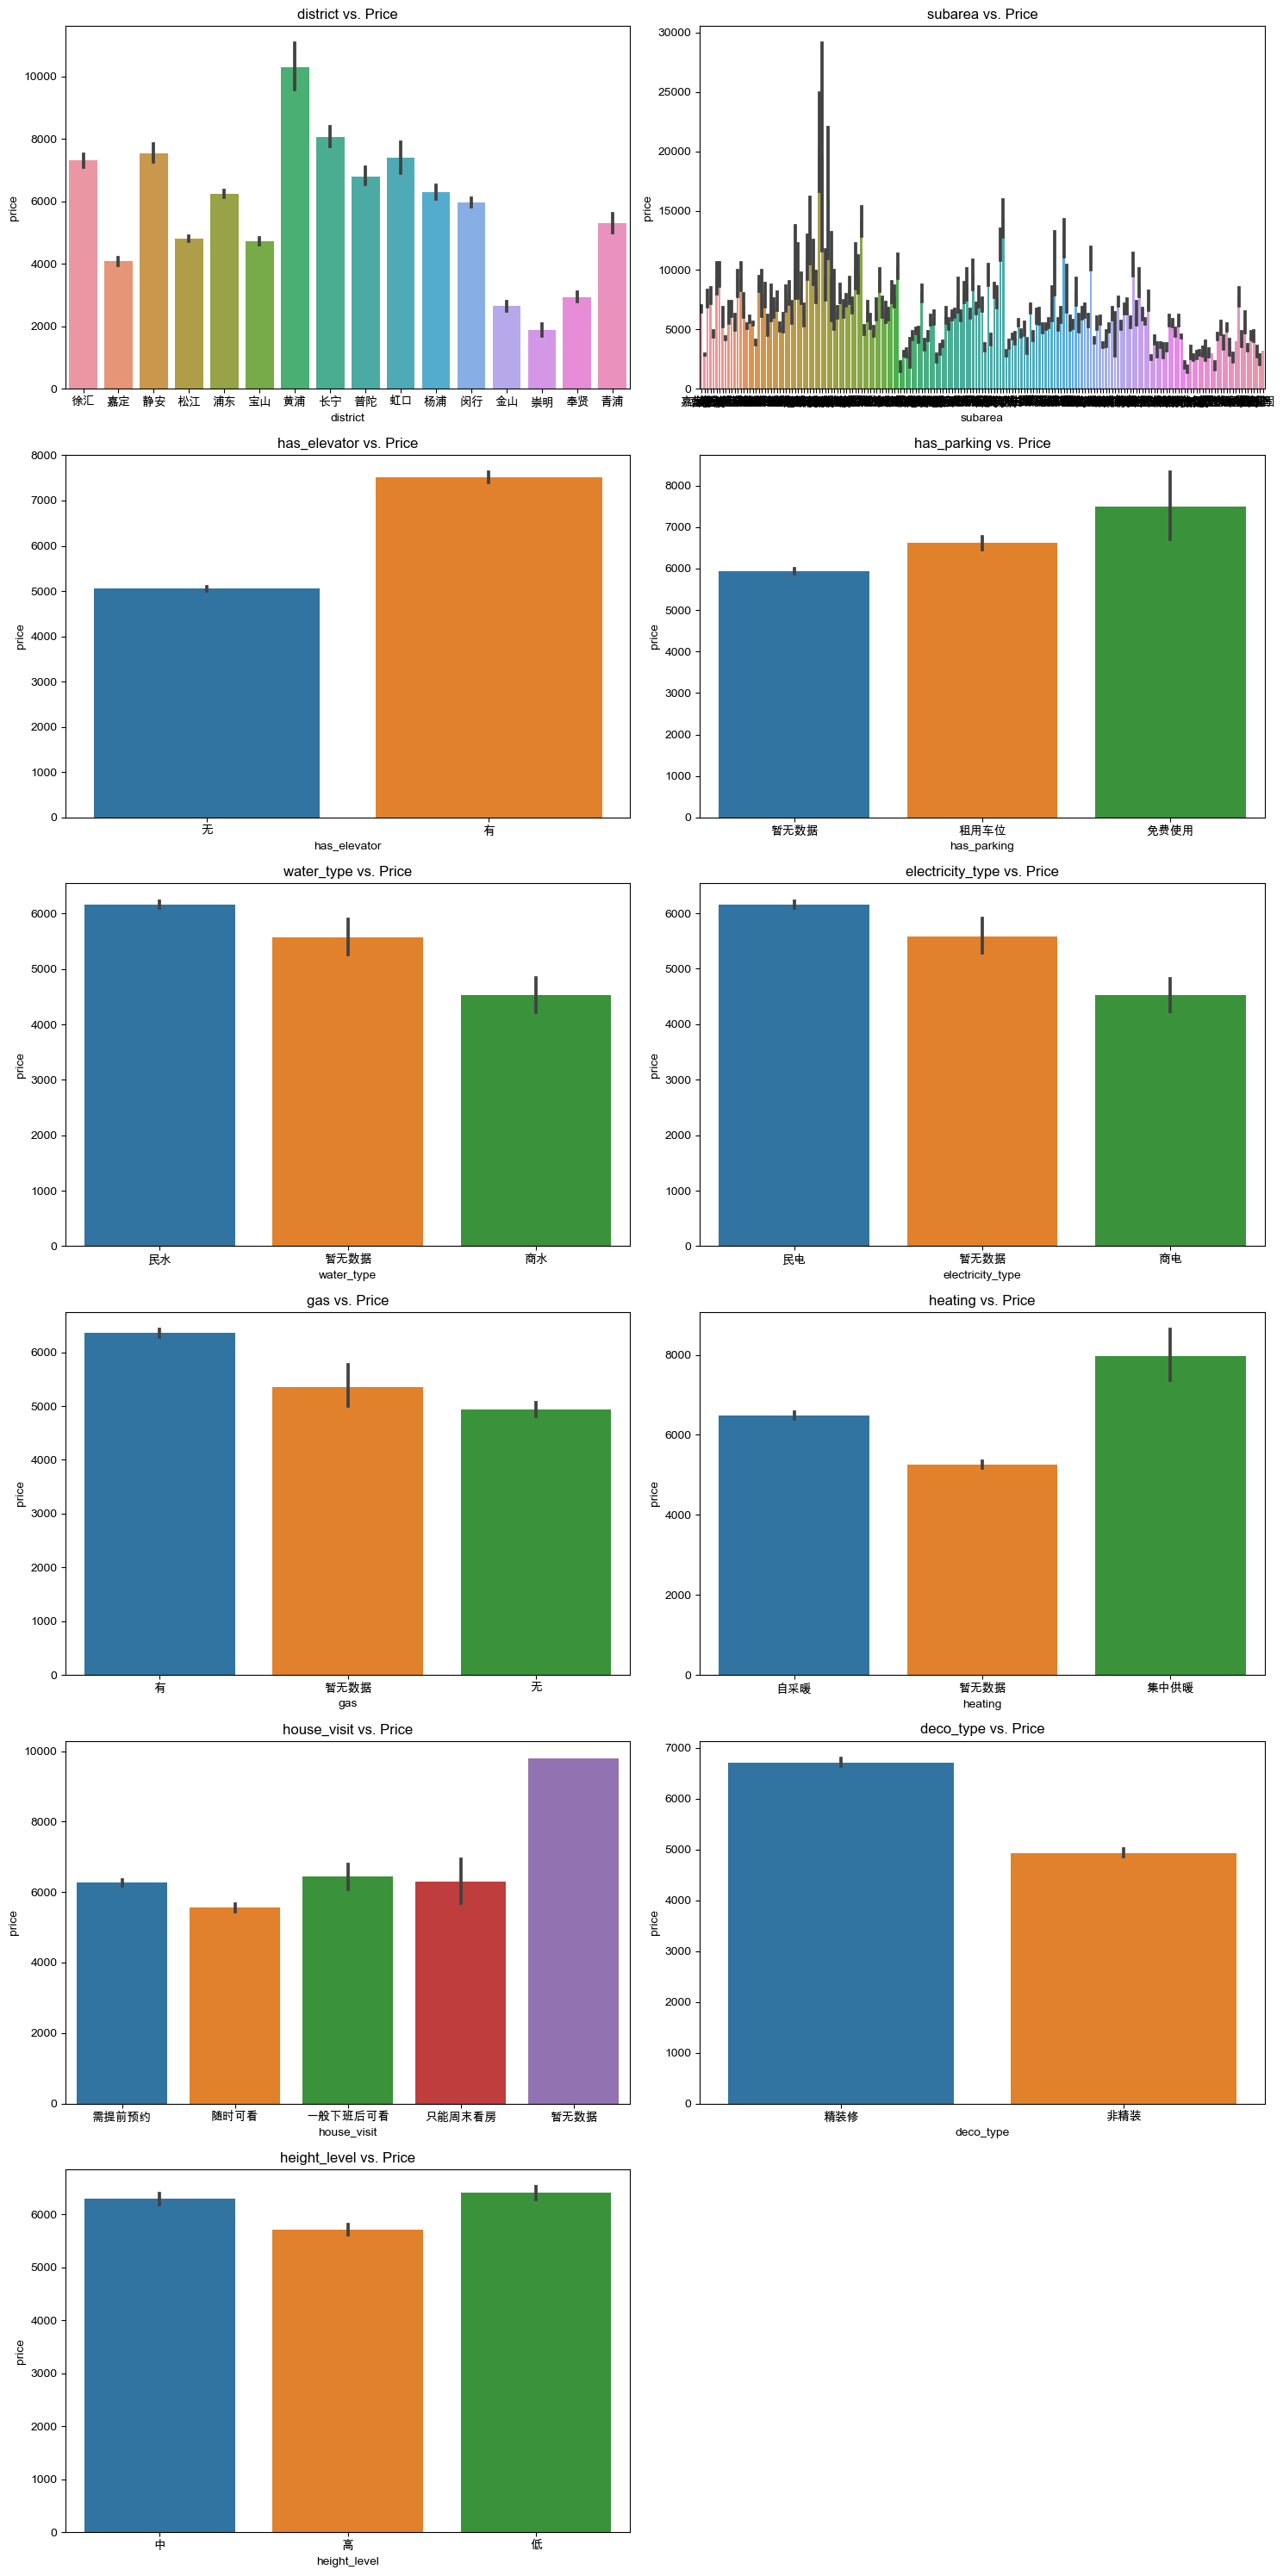

In [72]:
# Plotting bar charts for each categorical feature against the target 'price'
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.figure(figsize=(15, 30))

num_rows = 6
num_cols = 2

for i, feature in enumerate(categorical_columns):
  plt.subplot(num_rows, num_cols, i + 1)
  sns.barplot(x=feature, y='price', data=df, color=None)
  plt.title(f'{feature} vs. Price')

plt.tight_layout()
plt.show()

* Observing the bar charts, it's evident that `district` and `subarea` feature labels are numerous, offering general location information. However, the distribution across different districts and subareas shows no distinct patterns.
* The three categories within the variable `house_visit` exhibit minimal distinctions and encompass a significant amount of missing information.

* Retaining these variables could unnecessarily burden the model computationally.

* Therefore, for exploratory purposes only, we analyze these variables to gain insights into house rental prices in various locations. However, they will not be utilized in the regression model.

In [73]:
df.drop(['district', 'subarea', 'house_visit'], axis=1, inplace=True)

In [74]:
categorical_columns = []
for col in df.columns:
  if df[col].dtype == 'object':
    categorical_columns.append(col)

# Get all the catedorical features
categorical_columns

['has_elevator',
 'has_parking',
 'water_type',
 'electricity_type',
 'gas',
 'heating',
 'deco_type',
 'height_level']

# Preprocessing data for modelling

## Feature selection

### Correlation Coefficient

Correlation coefficient measures the strength and direction of a linear relationship between two variables. It ranges from -1 to 1, where:
* 1 indicates a perfect positive linear relationship,
* -1 indicates a perfect negative linear relationship, and
* 0 indicates no linear relationship.

Dropping highly correlated variables can remove redundancy, enhance model interpretability and reduce overfitting, and reduce computational load during training.

**Correlation coefficients whose magnitude are between 0.9 and 1.0 indicate variables which can be considered very highly correlate.**

In [75]:
numerical_columns

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'longitude',
 'latitude',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km',
 'num_facilities']

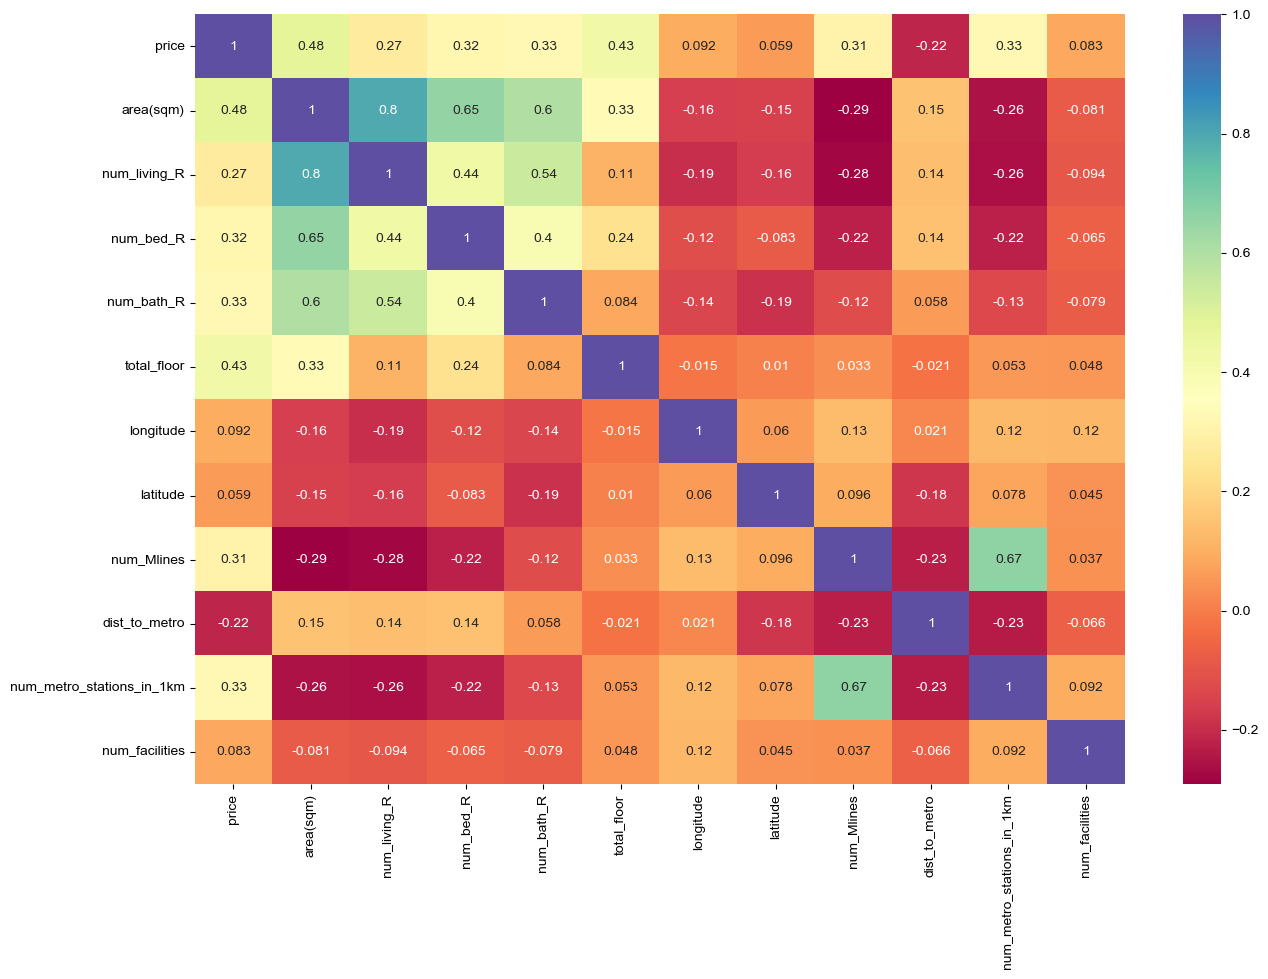

In [76]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical_columns].corr(), cmap='Spectral', annot=True)
plt.show()

In [77]:
# Check if there are highly correlated features

corr_matrix = df[numerical_columns].corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
tri_df = corr_matrix.mask(mask)

to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.9)]

print(f'There are {len(to_drop)} features need to be dropped.')

There are 0 features need to be dropped.


### Features low-correlated to target

In regression analysis, coefficients represent the relationships between the independent (predictor) variables and the dependent (response) variable. Each coefficient signifies the change in the dependent variable associated with a one-unit change in the corresponding independent variable, assuming other variables are held constant.

Removing features that are low-correlated to the target variable is a common practice in feature selection.

The interpretation of what constitutes a low, moderate, or high correlation coefficient can vary based on context and the specific requirements of a given analysis.

There is a general guideline often used:

- 0 to 0.2: Very weak correlation
- 0.2 to 0.4: Weak correlation
- 0.4 to 0.6: Moderate correlation
- 0.6 to 0.8: Strong correlation
- 0.8 to 1.0: Very strong correlation

In [78]:
numerical_columns

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'longitude',
 'latitude',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km',
 'num_facilities']

In [79]:
df[numerical_columns].corr()

price  area(sqm)  num_living_R  num_bed_R  \
price                      1.000000   0.477348      0.272756   0.315361   
area(sqm)                  0.477348   1.000000      0.797414   0.653120   
num_living_R               0.272756   0.797414      1.000000   0.438451   
num_bed_R                  0.315361   0.653120      0.438451   1.000000   
num_bath_R                 0.326011   0.600759      0.544659   0.398350   
total_floor                0.425028   0.330406      0.107110   0.235419   
longitude                  0.092075  -0.155816     -0.194899  -0.118410   
latitude                   0.059498  -0.151841     -0.161474  -0.083265   
num_Mlines                 0.306756  -0.291421     -0.276666  -0.222055   
dist_to_metro             -0.215639   0.151315      0.137633   0.143595   
num_metro_stations_in_1km  0.325804  -0.255607     -0.260451  -0.222338   
num_facilities             0.082672  -0.080888     -0.093554  -0.065170   

                           num_bath_R  total_floor  longitude  latitude  \
price                        0.326011     0.425028   0.092075  0.059498   
area(sqm)                    0.600759     0.330406  -0.155816 -0.151841   
num_living_R                 0.544659     0.107110  -0.194899 -0.161474   
num_bed_R                    0.398350     0.235419  -0.118410 -0.083265   
num_bath_R                   1.000000     0.084117  -0.137613 -0.185683   
total_floor                  0.084117     1.000000  -0.015021  0.010174   
longitude                   -0.137613    -0.015021   1.000000  0.060027   
latitude                    -0.185683     0.010174   0.060027  1.000000   
num_Mlines                  -0.120579     0.033482   0.130411  0.096436   
dist_to_metro                0.057528    -0.021279   0.020650 -0.180242   
num_metro_stations_in_1km   -0.131427     0.052520   0.124949  0.078239   
num_facilities              -0.078835     0.048021   0.118992  0.044583   

                           num_Mlines  dist_to_metro  \
price                        0.306756      -0.215639   
area(sqm)                   -0.291421       0.151315   
num_living_R                -0.276666       0.137633   
num_bed_R                   -0.222055       0.143595   
num_bath_R                  -0.120579       0.057528   
total_floor                  0.033482      -0.021279   
longitude                    0.130411       0.020650   
latitude                     0.096436      -0.180242   
num_Mlines                   1.000000      -0.229650   
dist_to_metro               -0.229650       1.000000   
num_metro_stations_in_1km    0.666975      -0.234861   
num_facilities               0.036788      -0.066083   

                           num_metro_stations_in_1km  num_facilities  
price                                       0.325804        0.082672  
area(sqm)                                  -0.255607       -0.080888  
num_living_R                               -0.260451       -0.093554  
num_bed_R                                  -0.222338       -0.065170  
num_bath_R                                 -0.131427       -0.078835  
total_floor                                 0.052520        0.048021  
longitude                                   0.124949        0.118992  
latitude                                    0.078239        0.044583  
num_Mlines                                  0.666975        0.036788  
dist_to_metro                              -0.234861       -0.066083  
num_metro_stations_in_1km                   1.000000        0.092060  
num_facilities                              0.092060        1.000000

In [80]:
corr_coef = df[numerical_columns].corr().abs().iloc[:, [0]].sort_values('price', ascending=False)
corr_coef

price
price                      1.000000
area(sqm)                  0.477348
total_floor                0.425028
num_bath_R                 0.326011
num_metro_stations_in_1km  0.325804
num_bed_R                  0.315361
num_Mlines                 0.306756
num_living_R               0.272756
dist_to_metro              0.215639
longitude                  0.092075
num_facilities             0.082672
latitude                   0.059498

In [81]:
to_drop = list(corr_coef[corr_coef['price']<0.2].index)
to_drop

['longitude', 'num_facilities', 'latitude']

In [82]:
df.drop(to_drop, axis=1, inplace=True)

In [83]:
df.head()

price  area(sqm) has_elevator has_parking water_type electricity_type gas  \
1   6300      33.06            无        暂无数据         民水               民电   有   
2   2800      82.90            无        暂无数据         民水               民电   有   
3   2900      22.80            无        暂无数据       暂无数据             暂无数据   有   
4   3000      37.71            无        租用车位         民水               民电   有   
5   3000      40.42            无        暂无数据         民水               民电   有   

  heating  num_living_R  num_bed_R  num_bath_R deco_type height_level  \
1     自采暖             1          1           1       精装修            中   
2     自采暖             2          2           1       精装修            高   
3     自采暖             1          1           1       非精装            中   
4     自采暖             1          1           1       非精装            高   
5     自采暖             1          1           1       非精装            高   

   total_floor  num_Mlines  dist_to_metro  num_metro_stations_in_1km  south  \
1            4           4       0.408018                          6   True   
2            6           0       1.707796                          0   True   
3            5           5       0.285941                          4   True   
4            6           1       0.533154                          2   True   
5            6           0       0.501036                          1   True   

    east  
1  False  
2  False  
3  False  
4  False  
5  False

In [84]:
numerical_columns = list(df.describe().columns)
numerical_columns

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km']

## One-hot encoding for categorial variables

In [85]:
categorical_columns

['has_elevator',
 'has_parking',
 'water_type',
 'electricity_type',
 'gas',
 'heating',
 'deco_type',
 'height_level']

In [86]:
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Optionally drop the original categorical column
# df_encoded = df_encoded.drop(columns=['column_to_encode'])


In [87]:
list(df_encoded.columns)

['price',
 'area(sqm)',
 'num_living_R',
 'num_bed_R',
 'num_bath_R',
 'total_floor',
 'num_Mlines',
 'dist_to_metro',
 'num_metro_stations_in_1km',
 'south',
 'east',
 'has_elevator_无',
 'has_elevator_有',
 'has_parking_免费使用',
 'has_parking_暂无数据',
 'has_parking_租用车位',
 'water_type_商水',
 'water_type_暂无数据',
 'water_type_民水',
 'electricity_type_商电',
 'electricity_type_暂无数据',
 'electricity_type_民电',
 'gas_无',
 'gas_暂无数据',
 'gas_有',
 'heating_暂无数据',
 'heating_自采暖',
 'heating_集中供暖',
 'deco_type_精装修',
 'deco_type_非精装',
 'height_level_中',
 'height_level_低',
 'height_level_高']

## Split into features and target

In [88]:
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

## Train_Test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8961, 32), (2241, 32), (8961,), (2241,))

## Feature scaling

In [90]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

In [91]:
results_df = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-Squared'])

def calculate_regression_metrics(y_test, y_pred, name):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  return [name, mse, rmse, mae, r2]

In [92]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
nn = Sequential()
nn.add(Dense(10, input_dim=len(X.columns), activation='relu'))
nn.add(Dense(1, activation='linear'))
nn.compile(loss='mean_squared_error', optimizer='adam')

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 200, max_depth = 5)
svm_reg = svm.SVR()

# List of models
models = [('Linear Regression', lr),
          ('Random Forest', rf),
          ('Gradient Boosting', gb),
          ('Neural Network', nn),
          ('XGBoost', xgb_reg),
          ('SVM', svm_reg)]

# Train and evaluate models
for name, model in models:
  if name == 'Neural Network':
    model.fit(np.array(X_train), np.array(y_train), epochs=50, verbose=0)
  else:
    model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  regression_metrics =calculate_regression_metrics(y_test, y_pred, name)
  results_df.loc[len(results_df)] = regression_metrics

# Create a DataFrame with the results
print(results_df)

               Model  Mean Squared Error  Root Mean Squared Error  \
0  Linear Regression        5.155321e+06              2270.533159   
1      Random Forest        2.744079e+06              1656.526266   
2  Gradient Boosting        3.451413e+06              1857.797828   
3     Neural Network        9.337058e+06              3055.660023   
4            XGBoost        2.775157e+06              1665.880105   
5                SVM        1.191709e+07              3452.114503   

   Mean Absolute Error  R-Squared  
0          1560.201717   0.557134  
1           974.726463   0.764271  
2          1162.979072   0.703508  
3          2377.411002   0.197904  
4          1000.578444   0.761601  
5          2047.885007  -0.023733  


In [93]:
results_df.sort_values('Mean Squared Error')

Model  Mean Squared Error  Root Mean Squared Error  \
1      Random Forest        2.744079e+06              1656.526266   
4            XGBoost        2.775157e+06              1665.880105   
2  Gradient Boosting        3.451413e+06              1857.797828   
0  Linear Regression        5.155321e+06              2270.533159   
3     Neural Network        9.337058e+06              3055.660023   
5                SVM        1.191709e+07              3452.114503   

   Mean Absolute Error  R-Squared  
1           974.726463   0.764271  
4          1000.578444   0.761601  
2          1162.979072   0.703508  
0          1560.201717   0.557134  
3          2377.411002   0.197904  
5          2047.885007  -0.023733

## Hyperprameter tuning
Hyperparameter tuning for 2 best performing models from above results : RandomForest, XGBoost

In [94]:
# Define the parameter grid
param_grid = {'n_estimators': [300, 500, 700],
              'min_samples_split': [2, 5, 10],
              'max_depth': [None, 5, 10]}

# Initialize the RF regressor
rf = RandomForestRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5, n_jobs=-1,
                           scoring ='neg_mean_absolute_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
rf_best_params = grid_search.best_params_
rf_best_score = grid_search.best_score_

print("Best Parameters:", rf_best_params)
print("Best Score (Negative Mean Squared Error):", rf_best_score)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best Score (Negative Mean Squared Error): -992.2451570280988


In [95]:
# Initialize the model with the best parameters

#rf_best_params={'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

rf_best = RandomForestRegressor(**rf_best_params, random_state=42)

# Fit the model
rf_best.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_best.predict(X_test)

# Calculate the metrics and add to results df
regression_metrics_rf_best =calculate_regression_metrics(y_test, y_pred, 'RandomForest_best')
results_df.loc[len(results_df)] = regression_metrics_rf_best

print(results_df)

               Model  Mean Squared Error  Root Mean Squared Error  \
0  Linear Regression        5.155321e+06              2270.533159   
1      Random Forest        2.744079e+06              1656.526266   
2  Gradient Boosting        3.451413e+06              1857.797828   
3     Neural Network        9.337058e+06              3055.660023   
4            XGBoost        2.775157e+06              1665.880105   
5                SVM        1.191709e+07              3452.114503   
6  RandomForest_best        2.752451e+06              1659.051186   

   Mean Absolute Error  R-Squared  
0          1560.201717   0.557134  
1           974.726463   0.764271  
2          1162.979072   0.703508  
3          2377.411002   0.197904  
4          1000.578444   0.761601  
5          2047.885007  -0.023733  
6           964.902663   0.763552  


In [96]:
results_df.sort_values('Mean Squared Error')

Model  Mean Squared Error  Root Mean Squared Error  \
1      Random Forest        2.744079e+06              1656.526266   
6  RandomForest_best        2.752451e+06              1659.051186   
4            XGBoost        2.775157e+06              1665.880105   
2  Gradient Boosting        3.451413e+06              1857.797828   
0  Linear Regression        5.155321e+06              2270.533159   
3     Neural Network        9.337058e+06              3055.660023   
5                SVM        1.191709e+07              3452.114503   

   Mean Absolute Error  R-Squared  
1           974.726463   0.764271  
6           964.902663   0.763552  
4          1000.578444   0.761601  
2          1162.979072   0.703508  
0          1560.201717   0.557134  
3          2377.411002   0.197904  
5          2047.885007  -0.023733

In general, the random_forest_best exhibits a slightly enhanced performance in terms of MAE and R-squared compared to the initial random forest model. However, there is a slight degradation in MSE, although these differences are relatively minor.

In [97]:
# Set up the parameter grid for grid search
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7, 10],
              'colsample_bytree': [0.5, 0.7, 1],
              'subsample': [0.5, 0.7, 1]}

# Initialize the XGBRegressor
xgb_reg = XGBRegressor(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the optimal parameters
xgb_best_params = grid_search.best_params_

print(xgb_best_params)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1}


In [98]:
# Initialize the model with the best parameters
# xgb_best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

xgb_best = XGBRegressor(**xgb_best_params, random_state=42)

# Fit the model
xgb_best.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_best.predict(X_test)

# Calculate the metrics and add to results df
regression_metrics_xgb_best =calculate_regression_metrics(y_test, y_pred, 'XGBoost_best')
results_df.loc[len(results_df)] = regression_metrics_xgb_best

print(results_df)

               Model  Mean Squared Error  Root Mean Squared Error  \
0  Linear Regression        5.155321e+06              2270.533159   
1      Random Forest        2.744079e+06              1656.526266   
2  Gradient Boosting        3.451413e+06              1857.797828   
3     Neural Network        9.337058e+06              3055.660023   
4            XGBoost        2.775157e+06              1665.880105   
5                SVM        1.191709e+07              3452.114503   
6  RandomForest_best        2.752451e+06              1659.051186   
7       XGBoost_best        2.796131e+06              1672.163693   

   Mean Absolute Error  R-Squared  
0          1560.201717   0.557134  
1           974.726463   0.764271  
2          1162.979072   0.703508  
3          2377.411002   0.197904  
4          1000.578444   0.761601  
5          2047.885007  -0.023733  
6           964.902663   0.763552  
7           934.712475   0.759800  


In [99]:
results_df.sort_values('Mean Squared Error')

Model  Mean Squared Error  Root Mean Squared Error  \
1      Random Forest        2.744079e+06              1656.526266   
6  RandomForest_best        2.752451e+06              1659.051186   
4            XGBoost        2.775157e+06              1665.880105   
7       XGBoost_best        2.796131e+06              1672.163693   
2  Gradient Boosting        3.451413e+06              1857.797828   
0  Linear Regression        5.155321e+06              2270.533159   
3     Neural Network        9.337058e+06              3055.660023   
5                SVM        1.191709e+07              3452.114503   

   Mean Absolute Error  R-Squared  
1           974.726463   0.764271  
6           964.902663   0.763552  
4          1000.578444   0.761601  
7           934.712475   0.759800  
2          1162.979072   0.703508  
0          1560.201717   0.557134  
3          2377.411002   0.197904  
5          2047.885007  -0.023733

Upon comparing the two sets of results, it's evident that the new outcomes from the XGBoost model with optimized parameters show slight improvements across all metrics. The Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error have slightly decreased, signifying enhanced predictive performance. Furthermore, the R-squared value has increased, indicating a better fit of the model to the data.

It's crucial to acknowledge that the improvements are relatively modest. However, they underscore the significance of parameter tuning in optimizing model performance. Exploring further iterations of parameter tuning, experimenting with different algorithms, or engaging in extensive feature engineering could potentially yield even more favorable results.

Having identified the optimal parameters for both models, my next step involves exploring Stacking. I plan to use Random Forest and XGBoost as base models, with other common models serving as the meta-learner. This strategy aims to leverage the strengths of different models for potentially improved predictive power.

## Stacking

In [100]:
print(rf_best_params)
print(xgb_best_params)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1}


In [101]:
# Define the base models
base_models = [('Random Forest', RandomForestRegressor(random_state=42, **rf_best_params)),
               ('XGBoost', xgb.XGBRegressor(random_state=42, **xgb_best_params))]

# Define the meta-models
meta_models = [('Linear Regression-meta', LinearRegression()),
               ('Ridge Regression-meta', RidgeCV()),
               ('Gradient Boosting-meta', GradientBoostingRegressor())]

# Perform stacking with different meta-models
results = []

for meta_name, meta_model in meta_models:
  stack_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model)
  stack_reg.fit(X_train, y_train)
  y_pred=stack_reg.predict(X_test)


  regression_metrics_meta =calculate_regression_metrics(y_test, y_pred, meta_name)
  results_df.loc[len(results_df)] = regression_metrics_meta

print(results_df)

                     Model  Mean Squared Error  Root Mean Squared Error  \
0        Linear Regression        5.155321e+06              2270.533159   
1            Random Forest        2.744079e+06              1656.526266   
2        Gradient Boosting        3.451413e+06              1857.797828   
3           Neural Network        9.337058e+06              3055.660023   
4                  XGBoost        2.775157e+06              1665.880105   
5                      SVM        1.191709e+07              3452.114503   
6        RandomForest_best        2.752451e+06              1659.051186   
7             XGBoost_best        2.796131e+06              1672.163693   
8   Linear Regression-meta        2.690689e+06              1640.331897   
9    Ridge Regression-meta        2.690689e+06              1640.331902   
10  Gradient Boosting-meta        2.778131e+06              1666.772736   

    Mean Absolute Error  R-Squared  
0           1560.201717   0.557134  
1            974.726463  

In [102]:
results_df.sort_values('Mean Squared Error')

Model  Mean Squared Error  Root Mean Squared Error  \
8   Linear Regression-meta        2.690689e+06              1640.331897   
9    Ridge Regression-meta        2.690689e+06              1640.331902   
1            Random Forest        2.744079e+06              1656.526266   
6        RandomForest_best        2.752451e+06              1659.051186   
4                  XGBoost        2.775157e+06              1665.880105   
10  Gradient Boosting-meta        2.778131e+06              1666.772736   
7             XGBoost_best        2.796131e+06              1672.163693   
2        Gradient Boosting        3.451413e+06              1857.797828   
0        Linear Regression        5.155321e+06              2270.533159   
3           Neural Network        9.337058e+06              3055.660023   
5                      SVM        1.191709e+07              3452.114503   

    Mean Absolute Error  R-Squared  
8            934.027893   0.768858  
9            934.027005   0.768858  
1            974.726463   0.764271  
6            964.902663   0.763552  
4           1000.578444   0.761601  
10           942.636902   0.761346  
7            934.712475   0.759800  
2           1162.979072   0.703508  
0           1560.201717   0.557134  
3           2377.411002   0.197904  
5           2047.885007  -0.023733

The stacking ensemble, incorporating linear regression and ridge regression as meta-models, demonstrated comparable performance. It exhibited lower mean squared error and root mean squared error, along with a higher R-squared, compared to the individual base models. On the other hand, the stacking ensemble with gradient boosting as the meta-model showed slightly inferior performance when contrasted with the linear and ridge regression models.

Upon evaluating all the models tested thus far, it's evident that stacking proves effective in achieving improved results. Consequently, I have decided to proceed with the model featuring Linear Regression as the meta-learner.

Next on the agenda is exploring the feature importance for the best-performing Random Forest model. This analysis aims to provide insights into the variables contributing significantly to the model's predictive capability.

## Feature importance

Check Feature importance for best Random Forest.

Top 10 Feature ranking:
1. Feature 0 (0.368897) - area(sqm)
2. Feature 5 (0.155926) - num_Mlines
3. Feature 6 (0.138155) - dist_to_metro
4. Feature 4 (0.106625) - total_floor
5. Feature 7 (0.088533) - num_metro_stations_in_1km
6. Feature 1 (0.015371) - num_living_R
7. Feature 10 (0.015325) - has_elevator_无
8. Feature 11 (0.013912) - has_elevator_有
9. Feature 27 (0.009991) - deco_type_精装修
10. Feature 28 (0.009438) - deco_type_非精装


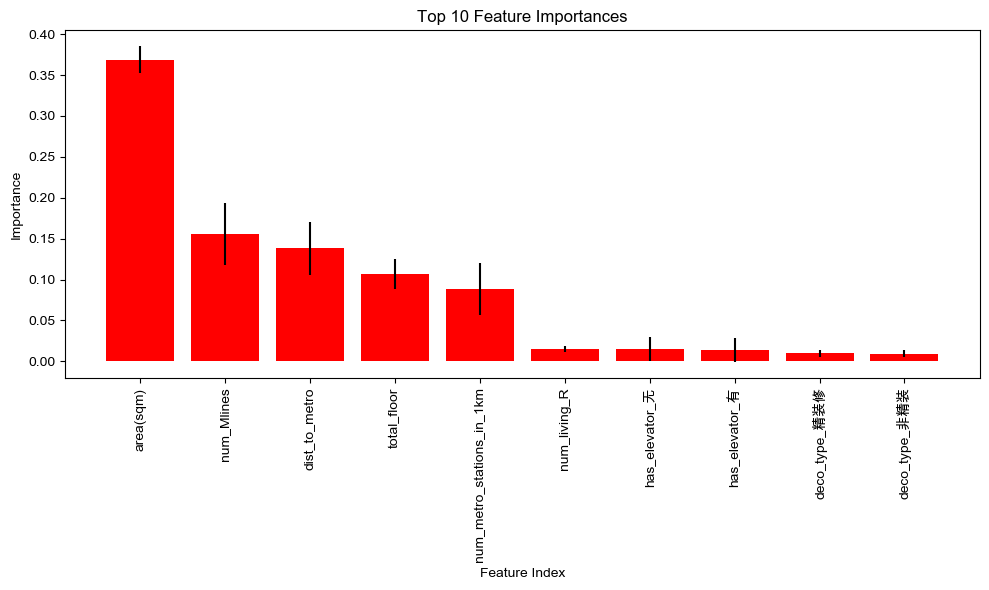

In [103]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Select the top N features for plotting
top_n = 10  # Adjust as needed
indices = indices[:top_n]
importances = importances[indices]
std = std[indices]

# Print the feature ranking
print("Top {} Feature ranking:".format(top_n))
for f in range(len(indices)):
    print("%d. Feature %d (%f) - %s" % (f + 1, indices[f], importances[f], X.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.title("Top {} Feature Importances".format(top_n))
plt.bar(range(len(indices)), importances, color="r", yerr=std, align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation='vertical')
plt.tight_layout()
plt.show()

Check feature importance for best XGBoost.

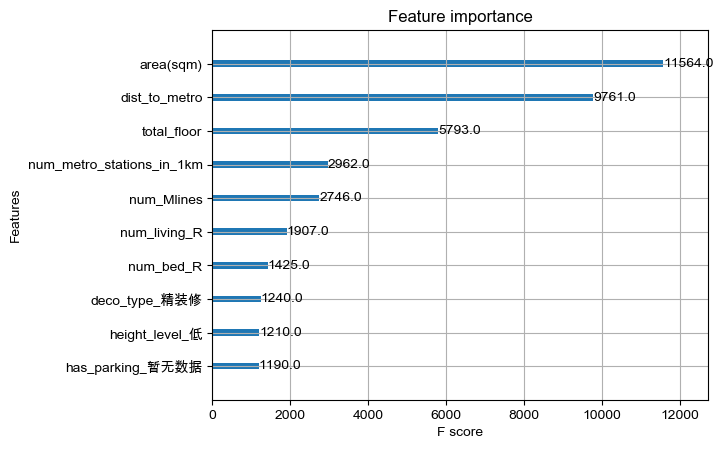

In [107]:
# Plot feature importance
xgb.plot_importance(xgb_best, max_num_features=10)
plt.show()